# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


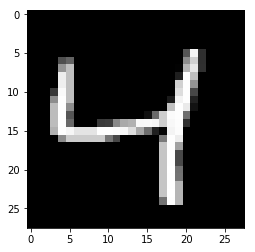

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [8]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32,(None,28,28,1),name='input')
targets_ = tf.placeholder(tf.float32,(None,28,28,1),name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (2,2), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 =  tf.layers.max_pooling2d(conv1, (5,5), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (2,2, padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (2,2), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (5,5), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (2,2), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (2,2), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv4,(28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (2,2), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(upsample3, 1, (2,2), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded =tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_,logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

SyntaxError: invalid syntax (<ipython-input-8-c23f84eb0ee9>, line 11)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [9]:
sess = tf.Session()

In [10]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7706
Epoch: 1/20... Training loss: 0.7288
Epoch: 1/20... Training loss: 0.7052
Epoch: 1/20... Training loss: 0.6909
Epoch: 1/20... Training loss: 0.6804
Epoch: 1/20... Training loss: 0.6709
Epoch: 1/20... Training loss: 0.6617
Epoch: 1/20... Training loss: 0.6499
Epoch: 1/20... Training loss: 0.6330
Epoch: 1/20... Training loss: 0.6106
Epoch: 1/20... Training loss: 0.5841
Epoch: 1/20... Training loss: 0.5559
Epoch: 1/20... Training loss: 0.5277
Epoch: 1/20... Training loss: 0.5127
Epoch: 1/20... Training loss: 0.4969
Epoch: 1/20... Training loss: 0.5057
Epoch: 1/20... Training loss: 0.5263
Epoch: 1/20... Training loss: 0.5268
Epoch: 1/20... Training loss: 0.5292
Epoch: 1/20... Training loss: 0.5022
Epoch: 1/20... Training loss: 0.4950
Epoch: 1/20... Training loss: 0.4898
Epoch: 1/20... Training loss: 0.4837
Epoch: 1/20... Training loss: 0.4748
Epoch: 1/20... Training loss: 0.4865
Epoch: 1/20... Training loss: 0.4934
Epoch: 1/20... Training loss: 0.4858
E

Epoch: 1/20... Training loss: 0.2210
Epoch: 1/20... Training loss: 0.2203
Epoch: 1/20... Training loss: 0.2145
Epoch: 1/20... Training loss: 0.2237
Epoch: 1/20... Training loss: 0.2217
Epoch: 1/20... Training loss: 0.2217
Epoch: 1/20... Training loss: 0.2269
Epoch: 1/20... Training loss: 0.2174
Epoch: 1/20... Training loss: 0.2137
Epoch: 1/20... Training loss: 0.2171
Epoch: 1/20... Training loss: 0.2165
Epoch: 1/20... Training loss: 0.2209
Epoch: 1/20... Training loss: 0.2111
Epoch: 1/20... Training loss: 0.2226
Epoch: 1/20... Training loss: 0.2219
Epoch: 1/20... Training loss: 0.2181
Epoch: 1/20... Training loss: 0.2121
Epoch: 1/20... Training loss: 0.2175
Epoch: 1/20... Training loss: 0.2177
Epoch: 1/20... Training loss: 0.2234
Epoch: 1/20... Training loss: 0.2147
Epoch: 1/20... Training loss: 0.2177
Epoch: 1/20... Training loss: 0.2133
Epoch: 1/20... Training loss: 0.2075
Epoch: 1/20... Training loss: 0.2181
Epoch: 1/20... Training loss: 0.2042
Epoch: 1/20... Training loss: 0.2064
E

Epoch: 2/20... Training loss: 0.1804
Epoch: 2/20... Training loss: 0.1842
Epoch: 2/20... Training loss: 0.1912
Epoch: 2/20... Training loss: 0.1893
Epoch: 2/20... Training loss: 0.1796
Epoch: 2/20... Training loss: 0.1875
Epoch: 2/20... Training loss: 0.1853
Epoch: 2/20... Training loss: 0.1877
Epoch: 2/20... Training loss: 0.1854
Epoch: 2/20... Training loss: 0.1893
Epoch: 2/20... Training loss: 0.1825
Epoch: 2/20... Training loss: 0.1849
Epoch: 2/20... Training loss: 0.1827
Epoch: 2/20... Training loss: 0.1861
Epoch: 2/20... Training loss: 0.1921
Epoch: 2/20... Training loss: 0.1929
Epoch: 2/20... Training loss: 0.1927
Epoch: 2/20... Training loss: 0.1823
Epoch: 2/20... Training loss: 0.1885
Epoch: 2/20... Training loss: 0.1877
Epoch: 2/20... Training loss: 0.1879
Epoch: 2/20... Training loss: 0.1851
Epoch: 2/20... Training loss: 0.1756
Epoch: 2/20... Training loss: 0.1879
Epoch: 2/20... Training loss: 0.1825
Epoch: 2/20... Training loss: 0.1845
Epoch: 2/20... Training loss: 0.1854
E

Epoch: 3/20... Training loss: 0.1680
Epoch: 3/20... Training loss: 0.1659
Epoch: 3/20... Training loss: 0.1728
Epoch: 3/20... Training loss: 0.1776
Epoch: 3/20... Training loss: 0.1714
Epoch: 3/20... Training loss: 0.1724
Epoch: 3/20... Training loss: 0.1711
Epoch: 3/20... Training loss: 0.1624
Epoch: 3/20... Training loss: 0.1688
Epoch: 3/20... Training loss: 0.1743
Epoch: 3/20... Training loss: 0.1687
Epoch: 3/20... Training loss: 0.1683
Epoch: 3/20... Training loss: 0.1712
Epoch: 3/20... Training loss: 0.1712
Epoch: 3/20... Training loss: 0.1720
Epoch: 3/20... Training loss: 0.1783
Epoch: 3/20... Training loss: 0.1724
Epoch: 3/20... Training loss: 0.1730
Epoch: 3/20... Training loss: 0.1768
Epoch: 3/20... Training loss: 0.1786
Epoch: 3/20... Training loss: 0.1732
Epoch: 3/20... Training loss: 0.1761
Epoch: 3/20... Training loss: 0.1629
Epoch: 3/20... Training loss: 0.1691
Epoch: 3/20... Training loss: 0.1783
Epoch: 3/20... Training loss: 0.1734
Epoch: 3/20... Training loss: 0.1791
E

Epoch: 3/20... Training loss: 0.1709
Epoch: 3/20... Training loss: 0.1699
Epoch: 3/20... Training loss: 0.1749
Epoch: 3/20... Training loss: 0.1645
Epoch: 4/20... Training loss: 0.1678
Epoch: 4/20... Training loss: 0.1582
Epoch: 4/20... Training loss: 0.1660
Epoch: 4/20... Training loss: 0.1689
Epoch: 4/20... Training loss: 0.1621
Epoch: 4/20... Training loss: 0.1670
Epoch: 4/20... Training loss: 0.1651
Epoch: 4/20... Training loss: 0.1647
Epoch: 4/20... Training loss: 0.1618
Epoch: 4/20... Training loss: 0.1636
Epoch: 4/20... Training loss: 0.1615
Epoch: 4/20... Training loss: 0.1647
Epoch: 4/20... Training loss: 0.1594
Epoch: 4/20... Training loss: 0.1684
Epoch: 4/20... Training loss: 0.1648
Epoch: 4/20... Training loss: 0.1692
Epoch: 4/20... Training loss: 0.1626
Epoch: 4/20... Training loss: 0.1642
Epoch: 4/20... Training loss: 0.1586
Epoch: 4/20... Training loss: 0.1661
Epoch: 4/20... Training loss: 0.1737
Epoch: 4/20... Training loss: 0.1648
Epoch: 4/20... Training loss: 0.1639
E

Epoch: 4/20... Training loss: 0.1652
Epoch: 4/20... Training loss: 0.1630
Epoch: 4/20... Training loss: 0.1541
Epoch: 4/20... Training loss: 0.1619
Epoch: 4/20... Training loss: 0.1595
Epoch: 4/20... Training loss: 0.1602
Epoch: 4/20... Training loss: 0.1599
Epoch: 4/20... Training loss: 0.1593
Epoch: 4/20... Training loss: 0.1478
Epoch: 4/20... Training loss: 0.1676
Epoch: 4/20... Training loss: 0.1601
Epoch: 4/20... Training loss: 0.1582
Epoch: 4/20... Training loss: 0.1623
Epoch: 4/20... Training loss: 0.1592
Epoch: 4/20... Training loss: 0.1603
Epoch: 4/20... Training loss: 0.1638
Epoch: 4/20... Training loss: 0.1640
Epoch: 4/20... Training loss: 0.1629
Epoch: 4/20... Training loss: 0.1574
Epoch: 4/20... Training loss: 0.1581
Epoch: 4/20... Training loss: 0.1637
Epoch: 4/20... Training loss: 0.1610
Epoch: 4/20... Training loss: 0.1595
Epoch: 4/20... Training loss: 0.1626
Epoch: 4/20... Training loss: 0.1607
Epoch: 4/20... Training loss: 0.1646
Epoch: 4/20... Training loss: 0.1537
E

Epoch: 5/20... Training loss: 0.1529
Epoch: 5/20... Training loss: 0.1611
Epoch: 5/20... Training loss: 0.1602
Epoch: 5/20... Training loss: 0.1609
Epoch: 5/20... Training loss: 0.1572
Epoch: 5/20... Training loss: 0.1600
Epoch: 5/20... Training loss: 0.1657
Epoch: 5/20... Training loss: 0.1572
Epoch: 5/20... Training loss: 0.1552
Epoch: 5/20... Training loss: 0.1556
Epoch: 5/20... Training loss: 0.1550
Epoch: 5/20... Training loss: 0.1606
Epoch: 5/20... Training loss: 0.1492
Epoch: 5/20... Training loss: 0.1558
Epoch: 5/20... Training loss: 0.1607
Epoch: 5/20... Training loss: 0.1561
Epoch: 5/20... Training loss: 0.1557
Epoch: 5/20... Training loss: 0.1624
Epoch: 5/20... Training loss: 0.1613
Epoch: 5/20... Training loss: 0.1596
Epoch: 5/20... Training loss: 0.1548
Epoch: 5/20... Training loss: 0.1579
Epoch: 5/20... Training loss: 0.1665
Epoch: 5/20... Training loss: 0.1667
Epoch: 5/20... Training loss: 0.1619
Epoch: 5/20... Training loss: 0.1575
Epoch: 5/20... Training loss: 0.1545
E

Epoch: 6/20... Training loss: 0.1563
Epoch: 6/20... Training loss: 0.1541
Epoch: 6/20... Training loss: 0.1549
Epoch: 6/20... Training loss: 0.1513
Epoch: 6/20... Training loss: 0.1527
Epoch: 6/20... Training loss: 0.1523
Epoch: 6/20... Training loss: 0.1511
Epoch: 6/20... Training loss: 0.1558
Epoch: 6/20... Training loss: 0.1598
Epoch: 6/20... Training loss: 0.1602
Epoch: 6/20... Training loss: 0.1565
Epoch: 6/20... Training loss: 0.1541
Epoch: 6/20... Training loss: 0.1579
Epoch: 6/20... Training loss: 0.1534
Epoch: 6/20... Training loss: 0.1549
Epoch: 6/20... Training loss: 0.1508
Epoch: 6/20... Training loss: 0.1562
Epoch: 6/20... Training loss: 0.1624
Epoch: 6/20... Training loss: 0.1537
Epoch: 6/20... Training loss: 0.1618
Epoch: 6/20... Training loss: 0.1517
Epoch: 6/20... Training loss: 0.1529
Epoch: 6/20... Training loss: 0.1510
Epoch: 6/20... Training loss: 0.1539
Epoch: 6/20... Training loss: 0.1543
Epoch: 6/20... Training loss: 0.1590
Epoch: 6/20... Training loss: 0.1553
E

Epoch: 6/20... Training loss: 0.1552
Epoch: 6/20... Training loss: 0.1588
Epoch: 6/20... Training loss: 0.1505
Epoch: 6/20... Training loss: 0.1513
Epoch: 6/20... Training loss: 0.1564
Epoch: 6/20... Training loss: 0.1542
Epoch: 6/20... Training loss: 0.1516
Epoch: 6/20... Training loss: 0.1467
Epoch: 6/20... Training loss: 0.1524
Epoch: 6/20... Training loss: 0.1477
Epoch: 7/20... Training loss: 0.1547
Epoch: 7/20... Training loss: 0.1540
Epoch: 7/20... Training loss: 0.1519
Epoch: 7/20... Training loss: 0.1542
Epoch: 7/20... Training loss: 0.1525
Epoch: 7/20... Training loss: 0.1489
Epoch: 7/20... Training loss: 0.1552
Epoch: 7/20... Training loss: 0.1555
Epoch: 7/20... Training loss: 0.1479
Epoch: 7/20... Training loss: 0.1539
Epoch: 7/20... Training loss: 0.1543
Epoch: 7/20... Training loss: 0.1551
Epoch: 7/20... Training loss: 0.1510
Epoch: 7/20... Training loss: 0.1480
Epoch: 7/20... Training loss: 0.1559
Epoch: 7/20... Training loss: 0.1486
Epoch: 7/20... Training loss: 0.1485
E

Epoch: 7/20... Training loss: 0.1521
Epoch: 7/20... Training loss: 0.1515
Epoch: 7/20... Training loss: 0.1450
Epoch: 7/20... Training loss: 0.1559
Epoch: 7/20... Training loss: 0.1443
Epoch: 7/20... Training loss: 0.1472
Epoch: 7/20... Training loss: 0.1457
Epoch: 7/20... Training loss: 0.1509
Epoch: 7/20... Training loss: 0.1449
Epoch: 7/20... Training loss: 0.1487
Epoch: 7/20... Training loss: 0.1437
Epoch: 7/20... Training loss: 0.1526
Epoch: 7/20... Training loss: 0.1532
Epoch: 7/20... Training loss: 0.1508
Epoch: 7/20... Training loss: 0.1424
Epoch: 7/20... Training loss: 0.1462
Epoch: 7/20... Training loss: 0.1451
Epoch: 7/20... Training loss: 0.1448
Epoch: 7/20... Training loss: 0.1493
Epoch: 7/20... Training loss: 0.1460
Epoch: 7/20... Training loss: 0.1512
Epoch: 7/20... Training loss: 0.1500
Epoch: 7/20... Training loss: 0.1521
Epoch: 7/20... Training loss: 0.1482
Epoch: 7/20... Training loss: 0.1489
Epoch: 7/20... Training loss: 0.1529
Epoch: 7/20... Training loss: 0.1490
E

Epoch: 8/20... Training loss: 0.1447
Epoch: 8/20... Training loss: 0.1463
Epoch: 8/20... Training loss: 0.1511
Epoch: 8/20... Training loss: 0.1470
Epoch: 8/20... Training loss: 0.1470
Epoch: 8/20... Training loss: 0.1453
Epoch: 8/20... Training loss: 0.1431
Epoch: 8/20... Training loss: 0.1489
Epoch: 8/20... Training loss: 0.1467
Epoch: 8/20... Training loss: 0.1453
Epoch: 8/20... Training loss: 0.1476
Epoch: 8/20... Training loss: 0.1452
Epoch: 8/20... Training loss: 0.1505
Epoch: 8/20... Training loss: 0.1491
Epoch: 8/20... Training loss: 0.1454
Epoch: 8/20... Training loss: 0.1520
Epoch: 8/20... Training loss: 0.1500
Epoch: 8/20... Training loss: 0.1445
Epoch: 8/20... Training loss: 0.1479
Epoch: 8/20... Training loss: 0.1563
Epoch: 8/20... Training loss: 0.1477
Epoch: 8/20... Training loss: 0.1454
Epoch: 8/20... Training loss: 0.1466
Epoch: 8/20... Training loss: 0.1513
Epoch: 8/20... Training loss: 0.1439
Epoch: 8/20... Training loss: 0.1501
Epoch: 8/20... Training loss: 0.1455
E

Epoch: 9/20... Training loss: 0.1449
Epoch: 9/20... Training loss: 0.1493
Epoch: 9/20... Training loss: 0.1430
Epoch: 9/20... Training loss: 0.1468
Epoch: 9/20... Training loss: 0.1396
Epoch: 9/20... Training loss: 0.1484
Epoch: 9/20... Training loss: 0.1431
Epoch: 9/20... Training loss: 0.1467
Epoch: 9/20... Training loss: 0.1481
Epoch: 9/20... Training loss: 0.1433
Epoch: 9/20... Training loss: 0.1423
Epoch: 9/20... Training loss: 0.1411
Epoch: 9/20... Training loss: 0.1502
Epoch: 9/20... Training loss: 0.1478
Epoch: 9/20... Training loss: 0.1463
Epoch: 9/20... Training loss: 0.1426
Epoch: 9/20... Training loss: 0.1449
Epoch: 9/20... Training loss: 0.1469
Epoch: 9/20... Training loss: 0.1466
Epoch: 9/20... Training loss: 0.1473
Epoch: 9/20... Training loss: 0.1432
Epoch: 9/20... Training loss: 0.1458
Epoch: 9/20... Training loss: 0.1403
Epoch: 9/20... Training loss: 0.1421
Epoch: 9/20... Training loss: 0.1440
Epoch: 9/20... Training loss: 0.1420
Epoch: 9/20... Training loss: 0.1444
E

Epoch: 9/20... Training loss: 0.1458
Epoch: 9/20... Training loss: 0.1487
Epoch: 9/20... Training loss: 0.1418
Epoch: 9/20... Training loss: 0.1438
Epoch: 9/20... Training loss: 0.1422
Epoch: 9/20... Training loss: 0.1417
Epoch: 9/20... Training loss: 0.1442
Epoch: 10/20... Training loss: 0.1413
Epoch: 10/20... Training loss: 0.1479
Epoch: 10/20... Training loss: 0.1403
Epoch: 10/20... Training loss: 0.1363
Epoch: 10/20... Training loss: 0.1429
Epoch: 10/20... Training loss: 0.1418
Epoch: 10/20... Training loss: 0.1420
Epoch: 10/20... Training loss: 0.1444
Epoch: 10/20... Training loss: 0.1462
Epoch: 10/20... Training loss: 0.1452
Epoch: 10/20... Training loss: 0.1361
Epoch: 10/20... Training loss: 0.1441
Epoch: 10/20... Training loss: 0.1433
Epoch: 10/20... Training loss: 0.1407
Epoch: 10/20... Training loss: 0.1451
Epoch: 10/20... Training loss: 0.1499
Epoch: 10/20... Training loss: 0.1447
Epoch: 10/20... Training loss: 0.1411
Epoch: 10/20... Training loss: 0.1380
Epoch: 10/20... Tra

Epoch: 10/20... Training loss: 0.1363
Epoch: 10/20... Training loss: 0.1391
Epoch: 10/20... Training loss: 0.1421
Epoch: 10/20... Training loss: 0.1362
Epoch: 10/20... Training loss: 0.1374
Epoch: 10/20... Training loss: 0.1451
Epoch: 10/20... Training loss: 0.1427
Epoch: 10/20... Training loss: 0.1398
Epoch: 10/20... Training loss: 0.1412
Epoch: 10/20... Training loss: 0.1428
Epoch: 10/20... Training loss: 0.1420
Epoch: 10/20... Training loss: 0.1401
Epoch: 10/20... Training loss: 0.1450
Epoch: 10/20... Training loss: 0.1405
Epoch: 10/20... Training loss: 0.1424
Epoch: 10/20... Training loss: 0.1413
Epoch: 10/20... Training loss: 0.1366
Epoch: 10/20... Training loss: 0.1420
Epoch: 10/20... Training loss: 0.1367
Epoch: 10/20... Training loss: 0.1429
Epoch: 10/20... Training loss: 0.1467
Epoch: 10/20... Training loss: 0.1361
Epoch: 10/20... Training loss: 0.1410
Epoch: 10/20... Training loss: 0.1436
Epoch: 10/20... Training loss: 0.1387
Epoch: 10/20... Training loss: 0.1426
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1420
Epoch: 11/20... Training loss: 0.1448
Epoch: 11/20... Training loss: 0.1401
Epoch: 11/20... Training loss: 0.1430
Epoch: 11/20... Training loss: 0.1350
Epoch: 11/20... Training loss: 0.1459
Epoch: 11/20... Training loss: 0.1369
Epoch: 11/20... Training loss: 0.1427
Epoch: 11/20... Training loss: 0.1409
Epoch: 11/20... Training loss: 0.1370
Epoch: 11/20... Training loss: 0.1359
Epoch: 11/20... Training loss: 0.1422
Epoch: 11/20... Training loss: 0.1361
Epoch: 11/20... Training loss: 0.1376
Epoch: 11/20... Training loss: 0.1399
Epoch: 11/20... Training loss: 0.1451
Epoch: 11/20... Training loss: 0.1384
Epoch: 11/20... Training loss: 0.1369
Epoch: 11/20... Training loss: 0.1388
Epoch: 11/20... Training loss: 0.1385
Epoch: 11/20... Training loss: 0.1418
Epoch: 11/20... Training loss: 0.1366
Epoch: 11/20... Training loss: 0.1377
Epoch: 11/20... Training loss: 0.1451
Epoch: 11/20... Training loss: 0.1357
Epoch: 11/20... Training loss: 0.1408
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1412
Epoch: 12/20... Training loss: 0.1375
Epoch: 12/20... Training loss: 0.1353
Epoch: 12/20... Training loss: 0.1394
Epoch: 12/20... Training loss: 0.1369
Epoch: 12/20... Training loss: 0.1404
Epoch: 12/20... Training loss: 0.1333
Epoch: 12/20... Training loss: 0.1432
Epoch: 12/20... Training loss: 0.1442
Epoch: 12/20... Training loss: 0.1441
Epoch: 12/20... Training loss: 0.1413
Epoch: 12/20... Training loss: 0.1397
Epoch: 12/20... Training loss: 0.1430
Epoch: 12/20... Training loss: 0.1374
Epoch: 12/20... Training loss: 0.1363
Epoch: 12/20... Training loss: 0.1341
Epoch: 12/20... Training loss: 0.1437
Epoch: 12/20... Training loss: 0.1348
Epoch: 12/20... Training loss: 0.1435
Epoch: 12/20... Training loss: 0.1359
Epoch: 12/20... Training loss: 0.1397
Epoch: 12/20... Training loss: 0.1417
Epoch: 12/20... Training loss: 0.1387
Epoch: 12/20... Training loss: 0.1415
Epoch: 12/20... Training loss: 0.1416
Epoch: 12/20... Training loss: 0.1326
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1314
Epoch: 12/20... Training loss: 0.1358
Epoch: 12/20... Training loss: 0.1414
Epoch: 12/20... Training loss: 0.1409
Epoch: 12/20... Training loss: 0.1391
Epoch: 12/20... Training loss: 0.1331
Epoch: 12/20... Training loss: 0.1389
Epoch: 12/20... Training loss: 0.1396
Epoch: 12/20... Training loss: 0.1390
Epoch: 12/20... Training loss: 0.1348
Epoch: 12/20... Training loss: 0.1349
Epoch: 12/20... Training loss: 0.1297
Epoch: 12/20... Training loss: 0.1322
Epoch: 12/20... Training loss: 0.1377
Epoch: 12/20... Training loss: 0.1442
Epoch: 12/20... Training loss: 0.1398
Epoch: 12/20... Training loss: 0.1340
Epoch: 12/20... Training loss: 0.1356
Epoch: 12/20... Training loss: 0.1362
Epoch: 12/20... Training loss: 0.1426
Epoch: 12/20... Training loss: 0.1354
Epoch: 12/20... Training loss: 0.1347
Epoch: 12/20... Training loss: 0.1317
Epoch: 12/20... Training loss: 0.1412
Epoch: 12/20... Training loss: 0.1409
Epoch: 12/20... Training loss: 0.1321
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1355
Epoch: 13/20... Training loss: 0.1354
Epoch: 13/20... Training loss: 0.1327
Epoch: 13/20... Training loss: 0.1405
Epoch: 13/20... Training loss: 0.1362
Epoch: 13/20... Training loss: 0.1366
Epoch: 13/20... Training loss: 0.1375
Epoch: 13/20... Training loss: 0.1370
Epoch: 13/20... Training loss: 0.1423
Epoch: 13/20... Training loss: 0.1347
Epoch: 13/20... Training loss: 0.1394
Epoch: 13/20... Training loss: 0.1384
Epoch: 13/20... Training loss: 0.1416
Epoch: 13/20... Training loss: 0.1404
Epoch: 13/20... Training loss: 0.1360
Epoch: 13/20... Training loss: 0.1445
Epoch: 13/20... Training loss: 0.1430
Epoch: 13/20... Training loss: 0.1370
Epoch: 13/20... Training loss: 0.1380
Epoch: 13/20... Training loss: 0.1381
Epoch: 13/20... Training loss: 0.1314
Epoch: 13/20... Training loss: 0.1331
Epoch: 13/20... Training loss: 0.1399
Epoch: 13/20... Training loss: 0.1358
Epoch: 13/20... Training loss: 0.1367
Epoch: 13/20... Training loss: 0.1382
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1390
Epoch: 14/20... Training loss: 0.1322
Epoch: 14/20... Training loss: 0.1400
Epoch: 14/20... Training loss: 0.1343
Epoch: 14/20... Training loss: 0.1342
Epoch: 14/20... Training loss: 0.1363
Epoch: 14/20... Training loss: 0.1406
Epoch: 14/20... Training loss: 0.1358
Epoch: 14/20... Training loss: 0.1334
Epoch: 14/20... Training loss: 0.1363
Epoch: 14/20... Training loss: 0.1335
Epoch: 14/20... Training loss: 0.1323
Epoch: 14/20... Training loss: 0.1359
Epoch: 14/20... Training loss: 0.1354
Epoch: 14/20... Training loss: 0.1375
Epoch: 14/20... Training loss: 0.1383
Epoch: 14/20... Training loss: 0.1341
Epoch: 14/20... Training loss: 0.1386
Epoch: 14/20... Training loss: 0.1296
Epoch: 14/20... Training loss: 0.1380
Epoch: 14/20... Training loss: 0.1329
Epoch: 14/20... Training loss: 0.1353
Epoch: 14/20... Training loss: 0.1381
Epoch: 14/20... Training loss: 0.1347
Epoch: 14/20... Training loss: 0.1373
Epoch: 14/20... Training loss: 0.1381
Epoch: 14/20

Epoch: 15/20... Training loss: 0.1326
Epoch: 15/20... Training loss: 0.1355
Epoch: 15/20... Training loss: 0.1352
Epoch: 15/20... Training loss: 0.1313
Epoch: 15/20... Training loss: 0.1296
Epoch: 15/20... Training loss: 0.1336
Epoch: 15/20... Training loss: 0.1322
Epoch: 15/20... Training loss: 0.1331
Epoch: 15/20... Training loss: 0.1376
Epoch: 15/20... Training loss: 0.1390
Epoch: 15/20... Training loss: 0.1382
Epoch: 15/20... Training loss: 0.1339
Epoch: 15/20... Training loss: 0.1329
Epoch: 15/20... Training loss: 0.1364
Epoch: 15/20... Training loss: 0.1318
Epoch: 15/20... Training loss: 0.1388
Epoch: 15/20... Training loss: 0.1310
Epoch: 15/20... Training loss: 0.1344
Epoch: 15/20... Training loss: 0.1340
Epoch: 15/20... Training loss: 0.1362
Epoch: 15/20... Training loss: 0.1369
Epoch: 15/20... Training loss: 0.1417
Epoch: 15/20... Training loss: 0.1349
Epoch: 15/20... Training loss: 0.1358
Epoch: 15/20... Training loss: 0.1382
Epoch: 15/20... Training loss: 0.1345
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1328
Epoch: 15/20... Training loss: 0.1292
Epoch: 15/20... Training loss: 0.1385
Epoch: 15/20... Training loss: 0.1330
Epoch: 15/20... Training loss: 0.1324
Epoch: 15/20... Training loss: 0.1357
Epoch: 15/20... Training loss: 0.1385
Epoch: 15/20... Training loss: 0.1333
Epoch: 15/20... Training loss: 0.1315
Epoch: 15/20... Training loss: 0.1315
Epoch: 15/20... Training loss: 0.1332
Epoch: 15/20... Training loss: 0.1345
Epoch: 15/20... Training loss: 0.1361
Epoch: 15/20... Training loss: 0.1345
Epoch: 15/20... Training loss: 0.1347
Epoch: 15/20... Training loss: 0.1376
Epoch: 15/20... Training loss: 0.1359
Epoch: 15/20... Training loss: 0.1352
Epoch: 15/20... Training loss: 0.1355
Epoch: 15/20... Training loss: 0.1318
Epoch: 15/20... Training loss: 0.1343
Epoch: 15/20... Training loss: 0.1295
Epoch: 15/20... Training loss: 0.1349
Epoch: 15/20... Training loss: 0.1373
Epoch: 15/20... Training loss: 0.1279
Epoch: 15/20... Training loss: 0.1320
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1331
Epoch: 16/20... Training loss: 0.1337
Epoch: 16/20... Training loss: 0.1381
Epoch: 16/20... Training loss: 0.1355
Epoch: 16/20... Training loss: 0.1364
Epoch: 16/20... Training loss: 0.1339
Epoch: 16/20... Training loss: 0.1314
Epoch: 16/20... Training loss: 0.1412
Epoch: 16/20... Training loss: 0.1273
Epoch: 16/20... Training loss: 0.1306
Epoch: 16/20... Training loss: 0.1320
Epoch: 16/20... Training loss: 0.1314
Epoch: 16/20... Training loss: 0.1309
Epoch: 16/20... Training loss: 0.1383
Epoch: 16/20... Training loss: 0.1319
Epoch: 16/20... Training loss: 0.1323
Epoch: 16/20... Training loss: 0.1326
Epoch: 16/20... Training loss: 0.1291
Epoch: 16/20... Training loss: 0.1292
Epoch: 16/20... Training loss: 0.1343
Epoch: 16/20... Training loss: 0.1348
Epoch: 16/20... Training loss: 0.1342
Epoch: 16/20... Training loss: 0.1286
Epoch: 16/20... Training loss: 0.1300
Epoch: 16/20... Training loss: 0.1350
Epoch: 16/20... Training loss: 0.1373
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1395
Epoch: 17/20... Training loss: 0.1314
Epoch: 17/20... Training loss: 0.1284
Epoch: 17/20... Training loss: 0.1319
Epoch: 17/20... Training loss: 0.1338
Epoch: 17/20... Training loss: 0.1352
Epoch: 17/20... Training loss: 0.1300
Epoch: 17/20... Training loss: 0.1357
Epoch: 17/20... Training loss: 0.1337
Epoch: 17/20... Training loss: 0.1308
Epoch: 17/20... Training loss: 0.1384
Epoch: 17/20... Training loss: 0.1336
Epoch: 17/20... Training loss: 0.1376
Epoch: 17/20... Training loss: 0.1364
Epoch: 17/20... Training loss: 0.1329
Epoch: 17/20... Training loss: 0.1298
Epoch: 17/20... Training loss: 0.1318
Epoch: 17/20... Training loss: 0.1343
Epoch: 17/20... Training loss: 0.1357
Epoch: 17/20... Training loss: 0.1325
Epoch: 17/20... Training loss: 0.1313
Epoch: 17/20... Training loss: 0.1328
Epoch: 17/20... Training loss: 0.1353
Epoch: 17/20... Training loss: 0.1360
Epoch: 17/20... Training loss: 0.1291
Epoch: 17/20... Training loss: 0.1314
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1344
Epoch: 17/20... Training loss: 0.1377
Epoch: 17/20... Training loss: 0.1265
Epoch: 17/20... Training loss: 0.1358
Epoch: 17/20... Training loss: 0.1317
Epoch: 17/20... Training loss: 0.1328
Epoch: 17/20... Training loss: 0.1321
Epoch: 18/20... Training loss: 0.1300
Epoch: 18/20... Training loss: 0.1301
Epoch: 18/20... Training loss: 0.1383
Epoch: 18/20... Training loss: 0.1348
Epoch: 18/20... Training loss: 0.1294
Epoch: 18/20... Training loss: 0.1316
Epoch: 18/20... Training loss: 0.1318
Epoch: 18/20... Training loss: 0.1392
Epoch: 18/20... Training loss: 0.1318
Epoch: 18/20... Training loss: 0.1359
Epoch: 18/20... Training loss: 0.1348
Epoch: 18/20... Training loss: 0.1346
Epoch: 18/20... Training loss: 0.1310
Epoch: 18/20... Training loss: 0.1352
Epoch: 18/20... Training loss: 0.1389
Epoch: 18/20... Training loss: 0.1347
Epoch: 18/20... Training loss: 0.1289
Epoch: 18/20... Training loss: 0.1351
Epoch: 18/20... Training loss: 0.1336
Epoch: 18/20

Epoch: 18/20... Training loss: 0.1325
Epoch: 18/20... Training loss: 0.1341
Epoch: 18/20... Training loss: 0.1318
Epoch: 18/20... Training loss: 0.1294
Epoch: 18/20... Training loss: 0.1291
Epoch: 18/20... Training loss: 0.1306
Epoch: 18/20... Training loss: 0.1356
Epoch: 18/20... Training loss: 0.1284
Epoch: 18/20... Training loss: 0.1303
Epoch: 18/20... Training loss: 0.1285
Epoch: 18/20... Training loss: 0.1258
Epoch: 18/20... Training loss: 0.1356
Epoch: 18/20... Training loss: 0.1303
Epoch: 18/20... Training loss: 0.1245
Epoch: 18/20... Training loss: 0.1369
Epoch: 18/20... Training loss: 0.1263
Epoch: 18/20... Training loss: 0.1276
Epoch: 18/20... Training loss: 0.1357
Epoch: 18/20... Training loss: 0.1292
Epoch: 18/20... Training loss: 0.1337
Epoch: 18/20... Training loss: 0.1277
Epoch: 18/20... Training loss: 0.1330
Epoch: 18/20... Training loss: 0.1281
Epoch: 18/20... Training loss: 0.1334
Epoch: 18/20... Training loss: 0.1348
Epoch: 18/20... Training loss: 0.1378
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1292
Epoch: 19/20... Training loss: 0.1299
Epoch: 19/20... Training loss: 0.1260
Epoch: 19/20... Training loss: 0.1359
Epoch: 19/20... Training loss: 0.1282
Epoch: 19/20... Training loss: 0.1283
Epoch: 19/20... Training loss: 0.1289
Epoch: 19/20... Training loss: 0.1317
Epoch: 19/20... Training loss: 0.1317
Epoch: 19/20... Training loss: 0.1345
Epoch: 19/20... Training loss: 0.1338
Epoch: 19/20... Training loss: 0.1277
Epoch: 19/20... Training loss: 0.1320
Epoch: 19/20... Training loss: 0.1300
Epoch: 19/20... Training loss: 0.1285
Epoch: 19/20... Training loss: 0.1300
Epoch: 19/20... Training loss: 0.1349
Epoch: 19/20... Training loss: 0.1290
Epoch: 19/20... Training loss: 0.1315
Epoch: 19/20... Training loss: 0.1321
Epoch: 19/20... Training loss: 0.1303
Epoch: 19/20... Training loss: 0.1273
Epoch: 19/20... Training loss: 0.1293
Epoch: 19/20... Training loss: 0.1271
Epoch: 19/20... Training loss: 0.1334
Epoch: 19/20... Training loss: 0.1275
Epoch: 19/20

Epoch: 20/20... Training loss: 0.1316
Epoch: 20/20... Training loss: 0.1333
Epoch: 20/20... Training loss: 0.1309
Epoch: 20/20... Training loss: 0.1342
Epoch: 20/20... Training loss: 0.1294
Epoch: 20/20... Training loss: 0.1330
Epoch: 20/20... Training loss: 0.1286
Epoch: 20/20... Training loss: 0.1330
Epoch: 20/20... Training loss: 0.1330
Epoch: 20/20... Training loss: 0.1332
Epoch: 20/20... Training loss: 0.1302
Epoch: 20/20... Training loss: 0.1270
Epoch: 20/20... Training loss: 0.1254
Epoch: 20/20... Training loss: 0.1284
Epoch: 20/20... Training loss: 0.1307
Epoch: 20/20... Training loss: 0.1292
Epoch: 20/20... Training loss: 0.1300
Epoch: 20/20... Training loss: 0.1319
Epoch: 20/20... Training loss: 0.1347
Epoch: 20/20... Training loss: 0.1309
Epoch: 20/20... Training loss: 0.1237
Epoch: 20/20... Training loss: 0.1342
Epoch: 20/20... Training loss: 0.1282
Epoch: 20/20... Training loss: 0.1316
Epoch: 20/20... Training loss: 0.1274
Epoch: 20/20... Training loss: 0.1298
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1300
Epoch: 20/20... Training loss: 0.1299
Epoch: 20/20... Training loss: 0.1314
Epoch: 20/20... Training loss: 0.1261
Epoch: 20/20... Training loss: 0.1289
Epoch: 20/20... Training loss: 0.1259
Epoch: 20/20... Training loss: 0.1287
Epoch: 20/20... Training loss: 0.1330
Epoch: 20/20... Training loss: 0.1343
Epoch: 20/20... Training loss: 0.1243
Epoch: 20/20... Training loss: 0.1280
Epoch: 20/20... Training loss: 0.1266
Epoch: 20/20... Training loss: 0.1252
Epoch: 20/20... Training loss: 0.1350
Epoch: 20/20... Training loss: 0.1347
Epoch: 20/20... Training loss: 0.1339
Epoch: 20/20... Training loss: 0.1276
Epoch: 20/20... Training loss: 0.1290
Epoch: 20/20... Training loss: 0.1303
Epoch: 20/20... Training loss: 0.1336
Epoch: 20/20... Training loss: 0.1267
Epoch: 20/20... Training loss: 0.1319
Epoch: 20/20... Training loss: 0.1292
Epoch: 20/20... Training loss: 0.1303
Epoch: 20/20... Training loss: 0.1262
Epoch: 20/20... Training loss: 0.1321
Epoch: 20/20

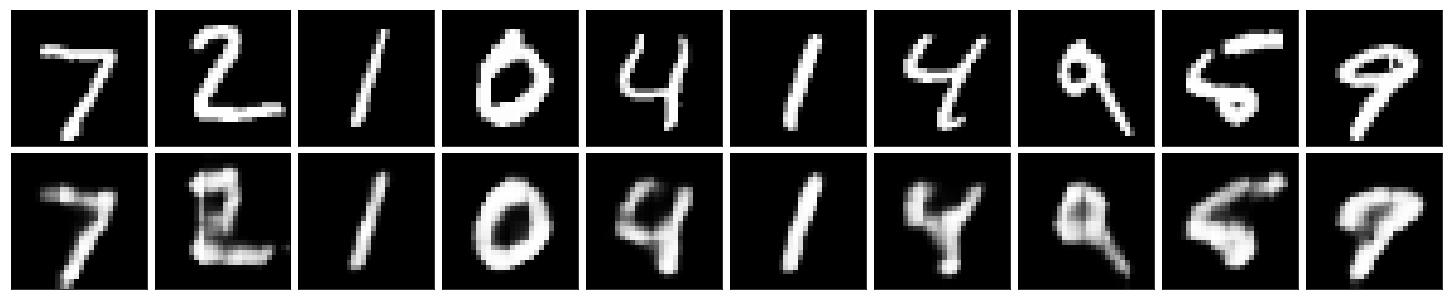

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [12]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [14]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (2,2), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 =  tf.layers.max_pooling2d(conv1, (3,3), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (2,2), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (3,3), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (2,2), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (3,3), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (2,2), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (2,2), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5,(28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (2,2), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(upsample3, 1, (2,2), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_,logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [15]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6639
Epoch: 1/100... Training loss: 0.6355
Epoch: 1/100... Training loss: 0.6052
Epoch: 1/100... Training loss: 0.5756
Epoch: 1/100... Training loss: 0.5511
Epoch: 1/100... Training loss: 0.5179
Epoch: 1/100... Training loss: 0.4988
Epoch: 1/100... Training loss: 0.4854
Epoch: 1/100... Training loss: 0.4952
Epoch: 1/100... Training loss: 0.5013
Epoch: 1/100... Training loss: 0.5052
Epoch: 1/100... Training loss: 0.5095
Epoch: 1/100... Training loss: 0.5170
Epoch: 1/100... Training loss: 0.4986
Epoch: 1/100... Training loss: 0.4762
Epoch: 1/100... Training loss: 0.4577
Epoch: 1/100... Training loss: 0.4660
Epoch: 1/100... Training loss: 0.4494
Epoch: 1/100... Training loss: 0.4576
Epoch: 1/100... Training loss: 0.4519
Epoch: 1/100... Training loss: 0.4387
Epoch: 1/100... Training loss: 0.4414
Epoch: 1/100... Training loss: 0.4414
Epoch: 1/100... Training loss: 0.4405
Epoch: 1/100... Training loss: 0.4412
Epoch: 1/100... Training loss: 0.4304
Epoch: 1/100

Epoch: 1/100... Training loss: 0.2699
Epoch: 1/100... Training loss: 0.2649
Epoch: 1/100... Training loss: 0.2634
Epoch: 1/100... Training loss: 0.2683
Epoch: 1/100... Training loss: 0.2659
Epoch: 1/100... Training loss: 0.2717
Epoch: 1/100... Training loss: 0.2701
Epoch: 1/100... Training loss: 0.2733
Epoch: 1/100... Training loss: 0.2693
Epoch: 1/100... Training loss: 0.2646
Epoch: 1/100... Training loss: 0.2599
Epoch: 1/100... Training loss: 0.2686
Epoch: 1/100... Training loss: 0.2742
Epoch: 1/100... Training loss: 0.2701
Epoch: 1/100... Training loss: 0.2626
Epoch: 1/100... Training loss: 0.2644
Epoch: 1/100... Training loss: 0.2646
Epoch: 1/100... Training loss: 0.2694
Epoch: 1/100... Training loss: 0.2750
Epoch: 1/100... Training loss: 0.2567
Epoch: 1/100... Training loss: 0.2637
Epoch: 1/100... Training loss: 0.2676
Epoch: 1/100... Training loss: 0.2644
Epoch: 1/100... Training loss: 0.2607
Epoch: 1/100... Training loss: 0.2651
Epoch: 1/100... Training loss: 0.2683
Epoch: 1/100

Epoch: 2/100... Training loss: 0.2409
Epoch: 2/100... Training loss: 0.2458
Epoch: 2/100... Training loss: 0.2453
Epoch: 2/100... Training loss: 0.2436
Epoch: 2/100... Training loss: 0.2512
Epoch: 2/100... Training loss: 0.2443
Epoch: 2/100... Training loss: 0.2454
Epoch: 2/100... Training loss: 0.2436
Epoch: 2/100... Training loss: 0.2411
Epoch: 2/100... Training loss: 0.2453
Epoch: 2/100... Training loss: 0.2368
Epoch: 2/100... Training loss: 0.2398
Epoch: 2/100... Training loss: 0.2490
Epoch: 2/100... Training loss: 0.2453
Epoch: 2/100... Training loss: 0.2445
Epoch: 2/100... Training loss: 0.2412
Epoch: 2/100... Training loss: 0.2447
Epoch: 2/100... Training loss: 0.2478
Epoch: 2/100... Training loss: 0.2412
Epoch: 2/100... Training loss: 0.2421
Epoch: 2/100... Training loss: 0.2476
Epoch: 2/100... Training loss: 0.2432
Epoch: 2/100... Training loss: 0.2517
Epoch: 2/100... Training loss: 0.2510
Epoch: 2/100... Training loss: 0.2394
Epoch: 2/100... Training loss: 0.2459
Epoch: 2/100

Epoch: 3/100... Training loss: 0.2324
Epoch: 3/100... Training loss: 0.2264
Epoch: 3/100... Training loss: 0.2299
Epoch: 3/100... Training loss: 0.2300
Epoch: 3/100... Training loss: 0.2318
Epoch: 3/100... Training loss: 0.2291
Epoch: 3/100... Training loss: 0.2307
Epoch: 3/100... Training loss: 0.2293
Epoch: 3/100... Training loss: 0.2274
Epoch: 3/100... Training loss: 0.2341
Epoch: 3/100... Training loss: 0.2278
Epoch: 3/100... Training loss: 0.2213
Epoch: 3/100... Training loss: 0.2337
Epoch: 3/100... Training loss: 0.2359
Epoch: 3/100... Training loss: 0.2241
Epoch: 3/100... Training loss: 0.2265
Epoch: 3/100... Training loss: 0.2251
Epoch: 3/100... Training loss: 0.2241
Epoch: 3/100... Training loss: 0.2297
Epoch: 3/100... Training loss: 0.2258
Epoch: 3/100... Training loss: 0.2253
Epoch: 3/100... Training loss: 0.2306
Epoch: 3/100... Training loss: 0.2238
Epoch: 3/100... Training loss: 0.2324
Epoch: 3/100... Training loss: 0.2379
Epoch: 3/100... Training loss: 0.2317
Epoch: 3/100

Epoch: 3/100... Training loss: 0.2185
Epoch: 3/100... Training loss: 0.2191
Epoch: 3/100... Training loss: 0.2179
Epoch: 3/100... Training loss: 0.2201
Epoch: 3/100... Training loss: 0.2225
Epoch: 3/100... Training loss: 0.2163
Epoch: 3/100... Training loss: 0.2163
Epoch: 3/100... Training loss: 0.2245
Epoch: 3/100... Training loss: 0.2200
Epoch: 3/100... Training loss: 0.2249
Epoch: 3/100... Training loss: 0.2210
Epoch: 3/100... Training loss: 0.2231
Epoch: 3/100... Training loss: 0.2200
Epoch: 3/100... Training loss: 0.2226
Epoch: 3/100... Training loss: 0.2243
Epoch: 3/100... Training loss: 0.2245
Epoch: 3/100... Training loss: 0.2145
Epoch: 3/100... Training loss: 0.2256
Epoch: 3/100... Training loss: 0.2258
Epoch: 3/100... Training loss: 0.2212
Epoch: 3/100... Training loss: 0.2132
Epoch: 3/100... Training loss: 0.2200
Epoch: 3/100... Training loss: 0.2191
Epoch: 3/100... Training loss: 0.2181
Epoch: 3/100... Training loss: 0.2203
Epoch: 3/100... Training loss: 0.2118
Epoch: 3/100

Epoch: 4/100... Training loss: 0.2135
Epoch: 4/100... Training loss: 0.2219
Epoch: 4/100... Training loss: 0.2150
Epoch: 4/100... Training loss: 0.2159
Epoch: 4/100... Training loss: 0.2134
Epoch: 4/100... Training loss: 0.2066
Epoch: 4/100... Training loss: 0.2173
Epoch: 4/100... Training loss: 0.2149
Epoch: 4/100... Training loss: 0.2150
Epoch: 4/100... Training loss: 0.2125
Epoch: 4/100... Training loss: 0.2130
Epoch: 4/100... Training loss: 0.2164
Epoch: 4/100... Training loss: 0.2212
Epoch: 4/100... Training loss: 0.2135
Epoch: 4/100... Training loss: 0.2051
Epoch: 4/100... Training loss: 0.2111
Epoch: 4/100... Training loss: 0.2172
Epoch: 4/100... Training loss: 0.2060
Epoch: 4/100... Training loss: 0.2114
Epoch: 4/100... Training loss: 0.2093
Epoch: 4/100... Training loss: 0.2111
Epoch: 4/100... Training loss: 0.2153
Epoch: 4/100... Training loss: 0.2132
Epoch: 4/100... Training loss: 0.2094
Epoch: 4/100... Training loss: 0.2097
Epoch: 4/100... Training loss: 0.2101
Epoch: 4/100

Epoch: 5/100... Training loss: 0.2086
Epoch: 5/100... Training loss: 0.2000
Epoch: 5/100... Training loss: 0.2115
Epoch: 5/100... Training loss: 0.2114
Epoch: 5/100... Training loss: 0.2070
Epoch: 5/100... Training loss: 0.2000
Epoch: 5/100... Training loss: 0.2105
Epoch: 5/100... Training loss: 0.2103
Epoch: 5/100... Training loss: 0.2134
Epoch: 5/100... Training loss: 0.2062
Epoch: 5/100... Training loss: 0.2078
Epoch: 5/100... Training loss: 0.2032
Epoch: 5/100... Training loss: 0.2119
Epoch: 5/100... Training loss: 0.2075
Epoch: 5/100... Training loss: 0.2118
Epoch: 5/100... Training loss: 0.2043
Epoch: 5/100... Training loss: 0.2131
Epoch: 5/100... Training loss: 0.2055
Epoch: 5/100... Training loss: 0.2031
Epoch: 5/100... Training loss: 0.2102
Epoch: 5/100... Training loss: 0.2139
Epoch: 5/100... Training loss: 0.2107
Epoch: 5/100... Training loss: 0.2126
Epoch: 5/100... Training loss: 0.2061
Epoch: 5/100... Training loss: 0.2021
Epoch: 5/100... Training loss: 0.2005
Epoch: 5/100

Epoch: 6/100... Training loss: 0.2060
Epoch: 6/100... Training loss: 0.2045
Epoch: 6/100... Training loss: 0.2011
Epoch: 6/100... Training loss: 0.2018
Epoch: 6/100... Training loss: 0.2052
Epoch: 6/100... Training loss: 0.2028
Epoch: 6/100... Training loss: 0.2019
Epoch: 6/100... Training loss: 0.2067
Epoch: 6/100... Training loss: 0.2086
Epoch: 6/100... Training loss: 0.2075
Epoch: 6/100... Training loss: 0.2012
Epoch: 6/100... Training loss: 0.2011
Epoch: 6/100... Training loss: 0.2077
Epoch: 6/100... Training loss: 0.2037
Epoch: 6/100... Training loss: 0.2033
Epoch: 6/100... Training loss: 0.2064
Epoch: 6/100... Training loss: 0.2050
Epoch: 6/100... Training loss: 0.2035
Epoch: 6/100... Training loss: 0.2069
Epoch: 6/100... Training loss: 0.2087
Epoch: 6/100... Training loss: 0.2039
Epoch: 6/100... Training loss: 0.2038
Epoch: 6/100... Training loss: 0.2073
Epoch: 6/100... Training loss: 0.2033
Epoch: 6/100... Training loss: 0.2046
Epoch: 6/100... Training loss: 0.2169
Epoch: 6/100

Epoch: 6/100... Training loss: 0.1991
Epoch: 6/100... Training loss: 0.1944
Epoch: 6/100... Training loss: 0.2056
Epoch: 6/100... Training loss: 0.1966
Epoch: 6/100... Training loss: 0.2044
Epoch: 6/100... Training loss: 0.2020
Epoch: 6/100... Training loss: 0.1946
Epoch: 6/100... Training loss: 0.2001
Epoch: 6/100... Training loss: 0.1984
Epoch: 6/100... Training loss: 0.2013
Epoch: 6/100... Training loss: 0.2053
Epoch: 6/100... Training loss: 0.1970
Epoch: 6/100... Training loss: 0.2034
Epoch: 6/100... Training loss: 0.2017
Epoch: 6/100... Training loss: 0.2018
Epoch: 6/100... Training loss: 0.1996
Epoch: 6/100... Training loss: 0.1933
Epoch: 6/100... Training loss: 0.2034
Epoch: 6/100... Training loss: 0.1984
Epoch: 6/100... Training loss: 0.2046
Epoch: 6/100... Training loss: 0.1992
Epoch: 6/100... Training loss: 0.2040
Epoch: 6/100... Training loss: 0.2011
Epoch: 6/100... Training loss: 0.1983
Epoch: 6/100... Training loss: 0.2017
Epoch: 6/100... Training loss: 0.2091
Epoch: 6/100

Epoch: 7/100... Training loss: 0.2015
Epoch: 7/100... Training loss: 0.2046
Epoch: 7/100... Training loss: 0.1989
Epoch: 7/100... Training loss: 0.1978
Epoch: 7/100... Training loss: 0.2023
Epoch: 7/100... Training loss: 0.2021
Epoch: 7/100... Training loss: 0.1971
Epoch: 7/100... Training loss: 0.1918
Epoch: 7/100... Training loss: 0.1985
Epoch: 7/100... Training loss: 0.1976
Epoch: 7/100... Training loss: 0.2006
Epoch: 7/100... Training loss: 0.2015
Epoch: 7/100... Training loss: 0.1951
Epoch: 7/100... Training loss: 0.1938
Epoch: 7/100... Training loss: 0.2019
Epoch: 7/100... Training loss: 0.1902
Epoch: 7/100... Training loss: 0.1904
Epoch: 7/100... Training loss: 0.1954
Epoch: 7/100... Training loss: 0.2009
Epoch: 7/100... Training loss: 0.2001
Epoch: 7/100... Training loss: 0.2022
Epoch: 7/100... Training loss: 0.1979
Epoch: 7/100... Training loss: 0.1966
Epoch: 7/100... Training loss: 0.1939
Epoch: 7/100... Training loss: 0.1950
Epoch: 7/100... Training loss: 0.1981
Epoch: 7/100

Epoch: 8/100... Training loss: 0.1991
Epoch: 8/100... Training loss: 0.1971
Epoch: 8/100... Training loss: 0.2001
Epoch: 8/100... Training loss: 0.1945
Epoch: 8/100... Training loss: 0.1928
Epoch: 8/100... Training loss: 0.1977
Epoch: 8/100... Training loss: 0.1920
Epoch: 8/100... Training loss: 0.1952
Epoch: 8/100... Training loss: 0.1915
Epoch: 8/100... Training loss: 0.1979
Epoch: 8/100... Training loss: 0.1953
Epoch: 8/100... Training loss: 0.1922
Epoch: 8/100... Training loss: 0.1966
Epoch: 8/100... Training loss: 0.1968
Epoch: 8/100... Training loss: 0.1931
Epoch: 8/100... Training loss: 0.1965
Epoch: 8/100... Training loss: 0.1926
Epoch: 8/100... Training loss: 0.1945
Epoch: 8/100... Training loss: 0.1924
Epoch: 8/100... Training loss: 0.1918
Epoch: 8/100... Training loss: 0.1942
Epoch: 8/100... Training loss: 0.1879
Epoch: 8/100... Training loss: 0.1939
Epoch: 8/100... Training loss: 0.1905
Epoch: 8/100... Training loss: 0.1996
Epoch: 8/100... Training loss: 0.1887
Epoch: 8/100

Epoch: 8/100... Training loss: 0.1954
Epoch: 8/100... Training loss: 0.1870
Epoch: 8/100... Training loss: 0.2007
Epoch: 8/100... Training loss: 0.1926
Epoch: 8/100... Training loss: 0.1939
Epoch: 8/100... Training loss: 0.1864
Epoch: 8/100... Training loss: 0.1944
Epoch: 8/100... Training loss: 0.1931
Epoch: 8/100... Training loss: 0.1874
Epoch: 8/100... Training loss: 0.1954
Epoch: 8/100... Training loss: 0.1907
Epoch: 8/100... Training loss: 0.1959
Epoch: 8/100... Training loss: 0.1938
Epoch: 8/100... Training loss: 0.1952
Epoch: 8/100... Training loss: 0.1809
Epoch: 9/100... Training loss: 0.1918
Epoch: 9/100... Training loss: 0.1906
Epoch: 9/100... Training loss: 0.1872
Epoch: 9/100... Training loss: 0.1882
Epoch: 9/100... Training loss: 0.1924
Epoch: 9/100... Training loss: 0.1904
Epoch: 9/100... Training loss: 0.1833
Epoch: 9/100... Training loss: 0.1884
Epoch: 9/100... Training loss: 0.1897
Epoch: 9/100... Training loss: 0.1919
Epoch: 9/100... Training loss: 0.1903
Epoch: 9/100

Epoch: 9/100... Training loss: 0.1939
Epoch: 9/100... Training loss: 0.1845
Epoch: 9/100... Training loss: 0.1905
Epoch: 9/100... Training loss: 0.1901
Epoch: 9/100... Training loss: 0.1884
Epoch: 9/100... Training loss: 0.1819
Epoch: 9/100... Training loss: 0.1893
Epoch: 9/100... Training loss: 0.1907
Epoch: 9/100... Training loss: 0.1849
Epoch: 9/100... Training loss: 0.1933
Epoch: 9/100... Training loss: 0.1851
Epoch: 9/100... Training loss: 0.1865
Epoch: 9/100... Training loss: 0.1873
Epoch: 9/100... Training loss: 0.1927
Epoch: 9/100... Training loss: 0.1888
Epoch: 9/100... Training loss: 0.1866
Epoch: 9/100... Training loss: 0.1885
Epoch: 9/100... Training loss: 0.1937
Epoch: 9/100... Training loss: 0.1809
Epoch: 9/100... Training loss: 0.1903
Epoch: 9/100... Training loss: 0.1881
Epoch: 9/100... Training loss: 0.1915
Epoch: 9/100... Training loss: 0.1888
Epoch: 9/100... Training loss: 0.1884
Epoch: 9/100... Training loss: 0.1932
Epoch: 9/100... Training loss: 0.1931
Epoch: 9/100

Epoch: 10/100... Training loss: 0.1790
Epoch: 10/100... Training loss: 0.1844
Epoch: 10/100... Training loss: 0.1856
Epoch: 10/100... Training loss: 0.1854
Epoch: 10/100... Training loss: 0.1877
Epoch: 10/100... Training loss: 0.1872
Epoch: 10/100... Training loss: 0.1867
Epoch: 10/100... Training loss: 0.1894
Epoch: 10/100... Training loss: 0.1897
Epoch: 10/100... Training loss: 0.1881
Epoch: 10/100... Training loss: 0.1836
Epoch: 10/100... Training loss: 0.1922
Epoch: 10/100... Training loss: 0.1869
Epoch: 10/100... Training loss: 0.1885
Epoch: 10/100... Training loss: 0.1899
Epoch: 10/100... Training loss: 0.1871
Epoch: 10/100... Training loss: 0.1841
Epoch: 10/100... Training loss: 0.1822
Epoch: 10/100... Training loss: 0.1842
Epoch: 10/100... Training loss: 0.1925
Epoch: 10/100... Training loss: 0.1881
Epoch: 10/100... Training loss: 0.1831
Epoch: 10/100... Training loss: 0.1883
Epoch: 10/100... Training loss: 0.1870
Epoch: 10/100... Training loss: 0.1863
Epoch: 10/100... Training

Epoch: 11/100... Training loss: 0.1827
Epoch: 11/100... Training loss: 0.1870
Epoch: 11/100... Training loss: 0.1855
Epoch: 11/100... Training loss: 0.1946
Epoch: 11/100... Training loss: 0.1822
Epoch: 11/100... Training loss: 0.1872
Epoch: 11/100... Training loss: 0.1850
Epoch: 11/100... Training loss: 0.1852
Epoch: 11/100... Training loss: 0.1882
Epoch: 11/100... Training loss: 0.1868
Epoch: 11/100... Training loss: 0.1873
Epoch: 11/100... Training loss: 0.1857
Epoch: 11/100... Training loss: 0.1906
Epoch: 11/100... Training loss: 0.1799
Epoch: 11/100... Training loss: 0.1893
Epoch: 11/100... Training loss: 0.1815
Epoch: 11/100... Training loss: 0.1778
Epoch: 11/100... Training loss: 0.1841
Epoch: 11/100... Training loss: 0.1826
Epoch: 11/100... Training loss: 0.1778
Epoch: 11/100... Training loss: 0.1834
Epoch: 11/100... Training loss: 0.1903
Epoch: 11/100... Training loss: 0.1779
Epoch: 11/100... Training loss: 0.1843
Epoch: 11/100... Training loss: 0.1817
Epoch: 11/100... Training

Epoch: 11/100... Training loss: 0.1874
Epoch: 11/100... Training loss: 0.1877
Epoch: 11/100... Training loss: 0.1894
Epoch: 11/100... Training loss: 0.1762
Epoch: 11/100... Training loss: 0.1822
Epoch: 11/100... Training loss: 0.1824
Epoch: 11/100... Training loss: 0.1743
Epoch: 11/100... Training loss: 0.1829
Epoch: 11/100... Training loss: 0.1839
Epoch: 11/100... Training loss: 0.1836
Epoch: 11/100... Training loss: 0.1840
Epoch: 11/100... Training loss: 0.1822
Epoch: 11/100... Training loss: 0.1848
Epoch: 11/100... Training loss: 0.1775
Epoch: 11/100... Training loss: 0.1861
Epoch: 11/100... Training loss: 0.1875
Epoch: 11/100... Training loss: 0.1837
Epoch: 11/100... Training loss: 0.1801
Epoch: 11/100... Training loss: 0.1760
Epoch: 11/100... Training loss: 0.1825
Epoch: 11/100... Training loss: 0.1745
Epoch: 11/100... Training loss: 0.1758
Epoch: 11/100... Training loss: 0.1821
Epoch: 11/100... Training loss: 0.1892
Epoch: 11/100... Training loss: 0.1830
Epoch: 11/100... Training

Epoch: 12/100... Training loss: 0.1788
Epoch: 12/100... Training loss: 0.1796
Epoch: 12/100... Training loss: 0.1850
Epoch: 12/100... Training loss: 0.1806
Epoch: 12/100... Training loss: 0.1799
Epoch: 12/100... Training loss: 0.1758
Epoch: 12/100... Training loss: 0.1746
Epoch: 12/100... Training loss: 0.1754
Epoch: 12/100... Training loss: 0.1882
Epoch: 12/100... Training loss: 0.1778
Epoch: 12/100... Training loss: 0.1838
Epoch: 12/100... Training loss: 0.1749
Epoch: 12/100... Training loss: 0.1812
Epoch: 12/100... Training loss: 0.1840
Epoch: 12/100... Training loss: 0.1778
Epoch: 12/100... Training loss: 0.1879
Epoch: 12/100... Training loss: 0.1817
Epoch: 12/100... Training loss: 0.1794
Epoch: 12/100... Training loss: 0.1749
Epoch: 12/100... Training loss: 0.1757
Epoch: 12/100... Training loss: 0.1760
Epoch: 12/100... Training loss: 0.1853
Epoch: 12/100... Training loss: 0.1858
Epoch: 12/100... Training loss: 0.1786
Epoch: 12/100... Training loss: 0.1779
Epoch: 12/100... Training

Epoch: 13/100... Training loss: 0.1766
Epoch: 13/100... Training loss: 0.1828
Epoch: 13/100... Training loss: 0.1731
Epoch: 13/100... Training loss: 0.1802
Epoch: 13/100... Training loss: 0.1775
Epoch: 13/100... Training loss: 0.1807
Epoch: 13/100... Training loss: 0.1730
Epoch: 13/100... Training loss: 0.1854
Epoch: 13/100... Training loss: 0.1810
Epoch: 13/100... Training loss: 0.1775
Epoch: 13/100... Training loss: 0.1790
Epoch: 13/100... Training loss: 0.1863
Epoch: 13/100... Training loss: 0.1811
Epoch: 13/100... Training loss: 0.1777
Epoch: 13/100... Training loss: 0.1854
Epoch: 13/100... Training loss: 0.1782
Epoch: 13/100... Training loss: 0.1784
Epoch: 13/100... Training loss: 0.1800
Epoch: 13/100... Training loss: 0.1795
Epoch: 13/100... Training loss: 0.1794
Epoch: 13/100... Training loss: 0.1794
Epoch: 13/100... Training loss: 0.1734
Epoch: 13/100... Training loss: 0.1867
Epoch: 13/100... Training loss: 0.1794
Epoch: 13/100... Training loss: 0.1818
Epoch: 13/100... Training

Epoch: 13/100... Training loss: 0.1718
Epoch: 13/100... Training loss: 0.1762
Epoch: 13/100... Training loss: 0.1857
Epoch: 13/100... Training loss: 0.1787
Epoch: 13/100... Training loss: 0.1803
Epoch: 13/100... Training loss: 0.1783
Epoch: 13/100... Training loss: 0.1793
Epoch: 13/100... Training loss: 0.1819
Epoch: 13/100... Training loss: 0.1795
Epoch: 13/100... Training loss: 0.1718
Epoch: 13/100... Training loss: 0.1786
Epoch: 13/100... Training loss: 0.1832
Epoch: 13/100... Training loss: 0.1783
Epoch: 13/100... Training loss: 0.1762
Epoch: 13/100... Training loss: 0.1758
Epoch: 13/100... Training loss: 0.1761
Epoch: 13/100... Training loss: 0.1770
Epoch: 13/100... Training loss: 0.1792
Epoch: 13/100... Training loss: 0.1807
Epoch: 13/100... Training loss: 0.1742
Epoch: 13/100... Training loss: 0.1766
Epoch: 14/100... Training loss: 0.1806
Epoch: 14/100... Training loss: 0.1749
Epoch: 14/100... Training loss: 0.1797
Epoch: 14/100... Training loss: 0.1741
Epoch: 14/100... Training

Epoch: 14/100... Training loss: 0.1745
Epoch: 14/100... Training loss: 0.1772
Epoch: 14/100... Training loss: 0.1731
Epoch: 14/100... Training loss: 0.1782
Epoch: 14/100... Training loss: 0.1748
Epoch: 14/100... Training loss: 0.1737
Epoch: 14/100... Training loss: 0.1755
Epoch: 14/100... Training loss: 0.1817
Epoch: 14/100... Training loss: 0.1750
Epoch: 14/100... Training loss: 0.1778
Epoch: 14/100... Training loss: 0.1709
Epoch: 14/100... Training loss: 0.1807
Epoch: 14/100... Training loss: 0.1788
Epoch: 14/100... Training loss: 0.1711
Epoch: 14/100... Training loss: 0.1789
Epoch: 14/100... Training loss: 0.1763
Epoch: 14/100... Training loss: 0.1798
Epoch: 14/100... Training loss: 0.1800
Epoch: 14/100... Training loss: 0.1758
Epoch: 14/100... Training loss: 0.1796
Epoch: 14/100... Training loss: 0.1769
Epoch: 14/100... Training loss: 0.1778
Epoch: 14/100... Training loss: 0.1764
Epoch: 14/100... Training loss: 0.1817
Epoch: 14/100... Training loss: 0.1759
Epoch: 14/100... Training

Epoch: 15/100... Training loss: 0.1764
Epoch: 15/100... Training loss: 0.1736
Epoch: 15/100... Training loss: 0.1720
Epoch: 15/100... Training loss: 0.1826
Epoch: 15/100... Training loss: 0.1657
Epoch: 15/100... Training loss: 0.1755
Epoch: 15/100... Training loss: 0.1724
Epoch: 15/100... Training loss: 0.1748
Epoch: 15/100... Training loss: 0.1704
Epoch: 15/100... Training loss: 0.1784
Epoch: 15/100... Training loss: 0.1706
Epoch: 15/100... Training loss: 0.1707
Epoch: 15/100... Training loss: 0.1679
Epoch: 15/100... Training loss: 0.1704
Epoch: 15/100... Training loss: 0.1708
Epoch: 15/100... Training loss: 0.1810
Epoch: 15/100... Training loss: 0.1763
Epoch: 15/100... Training loss: 0.1754
Epoch: 15/100... Training loss: 0.1747
Epoch: 15/100... Training loss: 0.1747
Epoch: 15/100... Training loss: 0.1740
Epoch: 15/100... Training loss: 0.1815
Epoch: 15/100... Training loss: 0.1764
Epoch: 15/100... Training loss: 0.1832
Epoch: 15/100... Training loss: 0.1737
Epoch: 15/100... Training

Epoch: 16/100... Training loss: 0.1771
Epoch: 16/100... Training loss: 0.1763
Epoch: 16/100... Training loss: 0.1714
Epoch: 16/100... Training loss: 0.1731
Epoch: 16/100... Training loss: 0.1751
Epoch: 16/100... Training loss: 0.1703
Epoch: 16/100... Training loss: 0.1738
Epoch: 16/100... Training loss: 0.1687
Epoch: 16/100... Training loss: 0.1776
Epoch: 16/100... Training loss: 0.1710
Epoch: 16/100... Training loss: 0.1683
Epoch: 16/100... Training loss: 0.1754
Epoch: 16/100... Training loss: 0.1683
Epoch: 16/100... Training loss: 0.1771
Epoch: 16/100... Training loss: 0.1754
Epoch: 16/100... Training loss: 0.1755
Epoch: 16/100... Training loss: 0.1733
Epoch: 16/100... Training loss: 0.1735
Epoch: 16/100... Training loss: 0.1737
Epoch: 16/100... Training loss: 0.1681
Epoch: 16/100... Training loss: 0.1768
Epoch: 16/100... Training loss: 0.1704
Epoch: 16/100... Training loss: 0.1724
Epoch: 16/100... Training loss: 0.1711
Epoch: 16/100... Training loss: 0.1785
Epoch: 16/100... Training

Epoch: 16/100... Training loss: 0.1710
Epoch: 16/100... Training loss: 0.1712
Epoch: 16/100... Training loss: 0.1734
Epoch: 16/100... Training loss: 0.1754
Epoch: 16/100... Training loss: 0.1771
Epoch: 16/100... Training loss: 0.1697
Epoch: 16/100... Training loss: 0.1716
Epoch: 16/100... Training loss: 0.1737
Epoch: 16/100... Training loss: 0.1725
Epoch: 16/100... Training loss: 0.1679
Epoch: 16/100... Training loss: 0.1744
Epoch: 16/100... Training loss: 0.1745
Epoch: 16/100... Training loss: 0.1733
Epoch: 16/100... Training loss: 0.1774
Epoch: 16/100... Training loss: 0.1711
Epoch: 16/100... Training loss: 0.1720
Epoch: 16/100... Training loss: 0.1722
Epoch: 16/100... Training loss: 0.1765
Epoch: 16/100... Training loss: 0.1725
Epoch: 16/100... Training loss: 0.1723
Epoch: 16/100... Training loss: 0.1697
Epoch: 16/100... Training loss: 0.1762
Epoch: 16/100... Training loss: 0.1698
Epoch: 16/100... Training loss: 0.1682
Epoch: 16/100... Training loss: 0.1725
Epoch: 16/100... Training

Epoch: 17/100... Training loss: 0.1701
Epoch: 17/100... Training loss: 0.1719
Epoch: 17/100... Training loss: 0.1704
Epoch: 17/100... Training loss: 0.1706
Epoch: 17/100... Training loss: 0.1694
Epoch: 17/100... Training loss: 0.1706
Epoch: 17/100... Training loss: 0.1688
Epoch: 17/100... Training loss: 0.1724
Epoch: 17/100... Training loss: 0.1730
Epoch: 17/100... Training loss: 0.1772
Epoch: 17/100... Training loss: 0.1722
Epoch: 17/100... Training loss: 0.1689
Epoch: 17/100... Training loss: 0.1731
Epoch: 17/100... Training loss: 0.1769
Epoch: 17/100... Training loss: 0.1662
Epoch: 17/100... Training loss: 0.1721
Epoch: 17/100... Training loss: 0.1700
Epoch: 17/100... Training loss: 0.1713
Epoch: 17/100... Training loss: 0.1629
Epoch: 17/100... Training loss: 0.1672
Epoch: 17/100... Training loss: 0.1689
Epoch: 17/100... Training loss: 0.1685
Epoch: 17/100... Training loss: 0.1729
Epoch: 17/100... Training loss: 0.1685
Epoch: 17/100... Training loss: 0.1751
Epoch: 17/100... Training

Epoch: 18/100... Training loss: 0.1683
Epoch: 18/100... Training loss: 0.1670
Epoch: 18/100... Training loss: 0.1686
Epoch: 18/100... Training loss: 0.1709
Epoch: 18/100... Training loss: 0.1721
Epoch: 18/100... Training loss: 0.1676
Epoch: 18/100... Training loss: 0.1690
Epoch: 18/100... Training loss: 0.1812
Epoch: 18/100... Training loss: 0.1690
Epoch: 18/100... Training loss: 0.1700
Epoch: 18/100... Training loss: 0.1747
Epoch: 18/100... Training loss: 0.1726
Epoch: 18/100... Training loss: 0.1691
Epoch: 18/100... Training loss: 0.1718
Epoch: 18/100... Training loss: 0.1646
Epoch: 18/100... Training loss: 0.1647
Epoch: 18/100... Training loss: 0.1715
Epoch: 18/100... Training loss: 0.1711
Epoch: 18/100... Training loss: 0.1714
Epoch: 18/100... Training loss: 0.1667
Epoch: 18/100... Training loss: 0.1650
Epoch: 18/100... Training loss: 0.1730
Epoch: 18/100... Training loss: 0.1681
Epoch: 18/100... Training loss: 0.1663
Epoch: 18/100... Training loss: 0.1666
Epoch: 18/100... Training

Epoch: 18/100... Training loss: 0.1639
Epoch: 18/100... Training loss: 0.1641
Epoch: 18/100... Training loss: 0.1706
Epoch: 18/100... Training loss: 0.1727
Epoch: 18/100... Training loss: 0.1673
Epoch: 18/100... Training loss: 0.1675
Epoch: 18/100... Training loss: 0.1672
Epoch: 18/100... Training loss: 0.1633
Epoch: 18/100... Training loss: 0.1756
Epoch: 18/100... Training loss: 0.1703
Epoch: 18/100... Training loss: 0.1725
Epoch: 18/100... Training loss: 0.1655
Epoch: 18/100... Training loss: 0.1687
Epoch: 18/100... Training loss: 0.1707
Epoch: 18/100... Training loss: 0.1716
Epoch: 18/100... Training loss: 0.1719
Epoch: 18/100... Training loss: 0.1688
Epoch: 18/100... Training loss: 0.1717
Epoch: 18/100... Training loss: 0.1697
Epoch: 18/100... Training loss: 0.1636
Epoch: 18/100... Training loss: 0.1681
Epoch: 18/100... Training loss: 0.1651
Epoch: 18/100... Training loss: 0.1739
Epoch: 18/100... Training loss: 0.1735
Epoch: 18/100... Training loss: 0.1675
Epoch: 18/100... Training

Epoch: 19/100... Training loss: 0.1723
Epoch: 19/100... Training loss: 0.1677
Epoch: 19/100... Training loss: 0.1696
Epoch: 19/100... Training loss: 0.1680
Epoch: 19/100... Training loss: 0.1692
Epoch: 19/100... Training loss: 0.1747
Epoch: 19/100... Training loss: 0.1699
Epoch: 19/100... Training loss: 0.1680
Epoch: 19/100... Training loss: 0.1666
Epoch: 19/100... Training loss: 0.1649
Epoch: 19/100... Training loss: 0.1626
Epoch: 19/100... Training loss: 0.1700
Epoch: 19/100... Training loss: 0.1685
Epoch: 19/100... Training loss: 0.1740
Epoch: 19/100... Training loss: 0.1654
Epoch: 19/100... Training loss: 0.1682
Epoch: 19/100... Training loss: 0.1708
Epoch: 19/100... Training loss: 0.1658
Epoch: 19/100... Training loss: 0.1680
Epoch: 19/100... Training loss: 0.1665
Epoch: 19/100... Training loss: 0.1624
Epoch: 19/100... Training loss: 0.1712
Epoch: 19/100... Training loss: 0.1678
Epoch: 19/100... Training loss: 0.1661
Epoch: 19/100... Training loss: 0.1700
Epoch: 19/100... Training

Epoch: 20/100... Training loss: 0.1667
Epoch: 20/100... Training loss: 0.1677
Epoch: 20/100... Training loss: 0.1653
Epoch: 20/100... Training loss: 0.1666
Epoch: 20/100... Training loss: 0.1705
Epoch: 20/100... Training loss: 0.1676
Epoch: 20/100... Training loss: 0.1623
Epoch: 20/100... Training loss: 0.1663
Epoch: 20/100... Training loss: 0.1709
Epoch: 20/100... Training loss: 0.1666
Epoch: 20/100... Training loss: 0.1722
Epoch: 20/100... Training loss: 0.1664
Epoch: 20/100... Training loss: 0.1683
Epoch: 20/100... Training loss: 0.1743
Epoch: 20/100... Training loss: 0.1685
Epoch: 20/100... Training loss: 0.1695
Epoch: 20/100... Training loss: 0.1656
Epoch: 20/100... Training loss: 0.1692
Epoch: 20/100... Training loss: 0.1681
Epoch: 20/100... Training loss: 0.1657
Epoch: 20/100... Training loss: 0.1700
Epoch: 20/100... Training loss: 0.1668
Epoch: 20/100... Training loss: 0.1691
Epoch: 20/100... Training loss: 0.1698
Epoch: 20/100... Training loss: 0.1627
Epoch: 20/100... Training

Epoch: 20/100... Training loss: 0.1680
Epoch: 21/100... Training loss: 0.1728
Epoch: 21/100... Training loss: 0.1686
Epoch: 21/100... Training loss: 0.1706
Epoch: 21/100... Training loss: 0.1682
Epoch: 21/100... Training loss: 0.1684
Epoch: 21/100... Training loss: 0.1674
Epoch: 21/100... Training loss: 0.1732
Epoch: 21/100... Training loss: 0.1693
Epoch: 21/100... Training loss: 0.1633
Epoch: 21/100... Training loss: 0.1698
Epoch: 21/100... Training loss: 0.1648
Epoch: 21/100... Training loss: 0.1694
Epoch: 21/100... Training loss: 0.1619
Epoch: 21/100... Training loss: 0.1668
Epoch: 21/100... Training loss: 0.1653
Epoch: 21/100... Training loss: 0.1656
Epoch: 21/100... Training loss: 0.1737
Epoch: 21/100... Training loss: 0.1717
Epoch: 21/100... Training loss: 0.1594
Epoch: 21/100... Training loss: 0.1669
Epoch: 21/100... Training loss: 0.1661
Epoch: 21/100... Training loss: 0.1679
Epoch: 21/100... Training loss: 0.1721
Epoch: 21/100... Training loss: 0.1637
Epoch: 21/100... Training

Epoch: 21/100... Training loss: 0.1695
Epoch: 21/100... Training loss: 0.1653
Epoch: 21/100... Training loss: 0.1617
Epoch: 21/100... Training loss: 0.1594
Epoch: 21/100... Training loss: 0.1652
Epoch: 21/100... Training loss: 0.1628
Epoch: 21/100... Training loss: 0.1695
Epoch: 21/100... Training loss: 0.1640
Epoch: 21/100... Training loss: 0.1636
Epoch: 21/100... Training loss: 0.1618
Epoch: 21/100... Training loss: 0.1621
Epoch: 21/100... Training loss: 0.1652
Epoch: 21/100... Training loss: 0.1721
Epoch: 21/100... Training loss: 0.1570
Epoch: 21/100... Training loss: 0.1684
Epoch: 21/100... Training loss: 0.1615
Epoch: 21/100... Training loss: 0.1613
Epoch: 21/100... Training loss: 0.1658
Epoch: 21/100... Training loss: 0.1643
Epoch: 21/100... Training loss: 0.1668
Epoch: 21/100... Training loss: 0.1595
Epoch: 21/100... Training loss: 0.1679
Epoch: 21/100... Training loss: 0.1657
Epoch: 21/100... Training loss: 0.1586
Epoch: 21/100... Training loss: 0.1650
Epoch: 21/100... Training

Epoch: 22/100... Training loss: 0.1696
Epoch: 22/100... Training loss: 0.1671
Epoch: 22/100... Training loss: 0.1712
Epoch: 22/100... Training loss: 0.1685
Epoch: 22/100... Training loss: 0.1604
Epoch: 22/100... Training loss: 0.1662
Epoch: 22/100... Training loss: 0.1638
Epoch: 22/100... Training loss: 0.1715
Epoch: 22/100... Training loss: 0.1697
Epoch: 22/100... Training loss: 0.1703
Epoch: 22/100... Training loss: 0.1684
Epoch: 22/100... Training loss: 0.1645
Epoch: 22/100... Training loss: 0.1682
Epoch: 22/100... Training loss: 0.1597
Epoch: 22/100... Training loss: 0.1681
Epoch: 22/100... Training loss: 0.1614
Epoch: 22/100... Training loss: 0.1668
Epoch: 22/100... Training loss: 0.1602
Epoch: 22/100... Training loss: 0.1666
Epoch: 22/100... Training loss: 0.1626
Epoch: 22/100... Training loss: 0.1640
Epoch: 22/100... Training loss: 0.1659
Epoch: 22/100... Training loss: 0.1580
Epoch: 22/100... Training loss: 0.1666
Epoch: 22/100... Training loss: 0.1636
Epoch: 22/100... Training

Epoch: 23/100... Training loss: 0.1631
Epoch: 23/100... Training loss: 0.1743
Epoch: 23/100... Training loss: 0.1576
Epoch: 23/100... Training loss: 0.1615
Epoch: 23/100... Training loss: 0.1650
Epoch: 23/100... Training loss: 0.1613
Epoch: 23/100... Training loss: 0.1659
Epoch: 23/100... Training loss: 0.1637
Epoch: 23/100... Training loss: 0.1665
Epoch: 23/100... Training loss: 0.1725
Epoch: 23/100... Training loss: 0.1658
Epoch: 23/100... Training loss: 0.1635
Epoch: 23/100... Training loss: 0.1700
Epoch: 23/100... Training loss: 0.1656
Epoch: 23/100... Training loss: 0.1595
Epoch: 23/100... Training loss: 0.1673
Epoch: 23/100... Training loss: 0.1688
Epoch: 23/100... Training loss: 0.1669
Epoch: 23/100... Training loss: 0.1634
Epoch: 23/100... Training loss: 0.1640
Epoch: 23/100... Training loss: 0.1673
Epoch: 23/100... Training loss: 0.1670
Epoch: 23/100... Training loss: 0.1701
Epoch: 23/100... Training loss: 0.1586
Epoch: 23/100... Training loss: 0.1666
Epoch: 23/100... Training

Epoch: 23/100... Training loss: 0.1623
Epoch: 23/100... Training loss: 0.1609
Epoch: 23/100... Training loss: 0.1603
Epoch: 23/100... Training loss: 0.1603
Epoch: 23/100... Training loss: 0.1612
Epoch: 23/100... Training loss: 0.1625
Epoch: 23/100... Training loss: 0.1667
Epoch: 23/100... Training loss: 0.1641
Epoch: 23/100... Training loss: 0.1641
Epoch: 23/100... Training loss: 0.1644
Epoch: 23/100... Training loss: 0.1619
Epoch: 23/100... Training loss: 0.1678
Epoch: 23/100... Training loss: 0.1592
Epoch: 23/100... Training loss: 0.1605
Epoch: 23/100... Training loss: 0.1644
Epoch: 23/100... Training loss: 0.1655
Epoch: 23/100... Training loss: 0.1596
Epoch: 23/100... Training loss: 0.1643
Epoch: 23/100... Training loss: 0.1702
Epoch: 23/100... Training loss: 0.1647
Epoch: 23/100... Training loss: 0.1636
Epoch: 23/100... Training loss: 0.1628
Epoch: 23/100... Training loss: 0.1653
Epoch: 23/100... Training loss: 0.1673
Epoch: 23/100... Training loss: 0.1617
Epoch: 23/100... Training

Epoch: 24/100... Training loss: 0.1655
Epoch: 24/100... Training loss: 0.1556
Epoch: 24/100... Training loss: 0.1659
Epoch: 24/100... Training loss: 0.1602
Epoch: 24/100... Training loss: 0.1666
Epoch: 24/100... Training loss: 0.1606
Epoch: 24/100... Training loss: 0.1625
Epoch: 24/100... Training loss: 0.1617
Epoch: 24/100... Training loss: 0.1624
Epoch: 24/100... Training loss: 0.1612
Epoch: 24/100... Training loss: 0.1583
Epoch: 24/100... Training loss: 0.1606
Epoch: 24/100... Training loss: 0.1648
Epoch: 24/100... Training loss: 0.1616
Epoch: 24/100... Training loss: 0.1635
Epoch: 24/100... Training loss: 0.1615
Epoch: 24/100... Training loss: 0.1663
Epoch: 24/100... Training loss: 0.1591
Epoch: 24/100... Training loss: 0.1639
Epoch: 24/100... Training loss: 0.1636
Epoch: 24/100... Training loss: 0.1637
Epoch: 24/100... Training loss: 0.1624
Epoch: 24/100... Training loss: 0.1598
Epoch: 24/100... Training loss: 0.1598
Epoch: 24/100... Training loss: 0.1624
Epoch: 24/100... Training

Epoch: 25/100... Training loss: 0.1632
Epoch: 25/100... Training loss: 0.1604
Epoch: 25/100... Training loss: 0.1657
Epoch: 25/100... Training loss: 0.1627
Epoch: 25/100... Training loss: 0.1581
Epoch: 25/100... Training loss: 0.1614
Epoch: 25/100... Training loss: 0.1653
Epoch: 25/100... Training loss: 0.1583
Epoch: 25/100... Training loss: 0.1606
Epoch: 25/100... Training loss: 0.1632
Epoch: 25/100... Training loss: 0.1602
Epoch: 25/100... Training loss: 0.1628
Epoch: 25/100... Training loss: 0.1616
Epoch: 25/100... Training loss: 0.1645
Epoch: 25/100... Training loss: 0.1623
Epoch: 25/100... Training loss: 0.1586
Epoch: 25/100... Training loss: 0.1593
Epoch: 25/100... Training loss: 0.1673
Epoch: 25/100... Training loss: 0.1667
Epoch: 25/100... Training loss: 0.1614
Epoch: 25/100... Training loss: 0.1659
Epoch: 25/100... Training loss: 0.1678
Epoch: 25/100... Training loss: 0.1645
Epoch: 25/100... Training loss: 0.1655
Epoch: 25/100... Training loss: 0.1640
Epoch: 25/100... Training

Epoch: 25/100... Training loss: 0.1597
Epoch: 25/100... Training loss: 0.1653
Epoch: 25/100... Training loss: 0.1622
Epoch: 25/100... Training loss: 0.1584
Epoch: 25/100... Training loss: 0.1625
Epoch: 25/100... Training loss: 0.1565
Epoch: 25/100... Training loss: 0.1645
Epoch: 25/100... Training loss: 0.1605
Epoch: 25/100... Training loss: 0.1620
Epoch: 25/100... Training loss: 0.1646
Epoch: 25/100... Training loss: 0.1608
Epoch: 25/100... Training loss: 0.1655
Epoch: 25/100... Training loss: 0.1627
Epoch: 25/100... Training loss: 0.1617
Epoch: 25/100... Training loss: 0.1641
Epoch: 26/100... Training loss: 0.1591
Epoch: 26/100... Training loss: 0.1656
Epoch: 26/100... Training loss: 0.1607
Epoch: 26/100... Training loss: 0.1619
Epoch: 26/100... Training loss: 0.1676
Epoch: 26/100... Training loss: 0.1582
Epoch: 26/100... Training loss: 0.1560
Epoch: 26/100... Training loss: 0.1591
Epoch: 26/100... Training loss: 0.1594
Epoch: 26/100... Training loss: 0.1611
Epoch: 26/100... Training

Epoch: 26/100... Training loss: 0.1597
Epoch: 26/100... Training loss: 0.1619
Epoch: 26/100... Training loss: 0.1591
Epoch: 26/100... Training loss: 0.1647
Epoch: 26/100... Training loss: 0.1603
Epoch: 26/100... Training loss: 0.1563
Epoch: 26/100... Training loss: 0.1740
Epoch: 26/100... Training loss: 0.1586
Epoch: 26/100... Training loss: 0.1644
Epoch: 26/100... Training loss: 0.1589
Epoch: 26/100... Training loss: 0.1604
Epoch: 26/100... Training loss: 0.1629
Epoch: 26/100... Training loss: 0.1682
Epoch: 26/100... Training loss: 0.1613
Epoch: 26/100... Training loss: 0.1642
Epoch: 26/100... Training loss: 0.1595
Epoch: 26/100... Training loss: 0.1549
Epoch: 26/100... Training loss: 0.1607
Epoch: 26/100... Training loss: 0.1591
Epoch: 26/100... Training loss: 0.1614
Epoch: 26/100... Training loss: 0.1618
Epoch: 26/100... Training loss: 0.1629
Epoch: 26/100... Training loss: 0.1635
Epoch: 26/100... Training loss: 0.1661
Epoch: 26/100... Training loss: 0.1650
Epoch: 26/100... Training

Epoch: 27/100... Training loss: 0.1635
Epoch: 27/100... Training loss: 0.1547
Epoch: 27/100... Training loss: 0.1629
Epoch: 27/100... Training loss: 0.1583
Epoch: 27/100... Training loss: 0.1629
Epoch: 27/100... Training loss: 0.1588
Epoch: 27/100... Training loss: 0.1641
Epoch: 27/100... Training loss: 0.1645
Epoch: 27/100... Training loss: 0.1550
Epoch: 27/100... Training loss: 0.1685
Epoch: 27/100... Training loss: 0.1607
Epoch: 27/100... Training loss: 0.1649
Epoch: 27/100... Training loss: 0.1616
Epoch: 27/100... Training loss: 0.1632
Epoch: 27/100... Training loss: 0.1599
Epoch: 27/100... Training loss: 0.1557
Epoch: 27/100... Training loss: 0.1587
Epoch: 27/100... Training loss: 0.1610
Epoch: 27/100... Training loss: 0.1603
Epoch: 27/100... Training loss: 0.1579
Epoch: 27/100... Training loss: 0.1599
Epoch: 27/100... Training loss: 0.1629
Epoch: 27/100... Training loss: 0.1608
Epoch: 27/100... Training loss: 0.1591
Epoch: 27/100... Training loss: 0.1607
Epoch: 27/100... Training

Epoch: 28/100... Training loss: 0.1609
Epoch: 28/100... Training loss: 0.1620
Epoch: 28/100... Training loss: 0.1615
Epoch: 28/100... Training loss: 0.1644
Epoch: 28/100... Training loss: 0.1575
Epoch: 28/100... Training loss: 0.1566
Epoch: 28/100... Training loss: 0.1598
Epoch: 28/100... Training loss: 0.1571
Epoch: 28/100... Training loss: 0.1643
Epoch: 28/100... Training loss: 0.1550
Epoch: 28/100... Training loss: 0.1570
Epoch: 28/100... Training loss: 0.1575
Epoch: 28/100... Training loss: 0.1583
Epoch: 28/100... Training loss: 0.1600
Epoch: 28/100... Training loss: 0.1608
Epoch: 28/100... Training loss: 0.1620
Epoch: 28/100... Training loss: 0.1597
Epoch: 28/100... Training loss: 0.1609
Epoch: 28/100... Training loss: 0.1637
Epoch: 28/100... Training loss: 0.1630
Epoch: 28/100... Training loss: 0.1570
Epoch: 28/100... Training loss: 0.1573
Epoch: 28/100... Training loss: 0.1610
Epoch: 28/100... Training loss: 0.1636
Epoch: 28/100... Training loss: 0.1608
Epoch: 28/100... Training

Epoch: 28/100... Training loss: 0.1604
Epoch: 28/100... Training loss: 0.1601
Epoch: 28/100... Training loss: 0.1614
Epoch: 28/100... Training loss: 0.1570
Epoch: 28/100... Training loss: 0.1597
Epoch: 28/100... Training loss: 0.1625
Epoch: 28/100... Training loss: 0.1578
Epoch: 28/100... Training loss: 0.1549
Epoch: 28/100... Training loss: 0.1569
Epoch: 28/100... Training loss: 0.1579
Epoch: 28/100... Training loss: 0.1642
Epoch: 28/100... Training loss: 0.1619
Epoch: 28/100... Training loss: 0.1547
Epoch: 28/100... Training loss: 0.1598
Epoch: 28/100... Training loss: 0.1612
Epoch: 28/100... Training loss: 0.1582
Epoch: 28/100... Training loss: 0.1608
Epoch: 28/100... Training loss: 0.1592
Epoch: 28/100... Training loss: 0.1592
Epoch: 28/100... Training loss: 0.1571
Epoch: 28/100... Training loss: 0.1601
Epoch: 28/100... Training loss: 0.1562
Epoch: 28/100... Training loss: 0.1566
Epoch: 28/100... Training loss: 0.1562
Epoch: 28/100... Training loss: 0.1639
Epoch: 28/100... Training

Epoch: 29/100... Training loss: 0.1542
Epoch: 29/100... Training loss: 0.1586
Epoch: 29/100... Training loss: 0.1625
Epoch: 29/100... Training loss: 0.1615
Epoch: 29/100... Training loss: 0.1590
Epoch: 29/100... Training loss: 0.1595
Epoch: 29/100... Training loss: 0.1590
Epoch: 29/100... Training loss: 0.1606
Epoch: 29/100... Training loss: 0.1569
Epoch: 29/100... Training loss: 0.1608
Epoch: 29/100... Training loss: 0.1612
Epoch: 29/100... Training loss: 0.1587
Epoch: 29/100... Training loss: 0.1550
Epoch: 29/100... Training loss: 0.1607
Epoch: 29/100... Training loss: 0.1548
Epoch: 29/100... Training loss: 0.1622
Epoch: 29/100... Training loss: 0.1592
Epoch: 29/100... Training loss: 0.1628
Epoch: 29/100... Training loss: 0.1553
Epoch: 29/100... Training loss: 0.1619
Epoch: 29/100... Training loss: 0.1658
Epoch: 29/100... Training loss: 0.1630
Epoch: 29/100... Training loss: 0.1569
Epoch: 29/100... Training loss: 0.1601
Epoch: 29/100... Training loss: 0.1589
Epoch: 29/100... Training

Epoch: 30/100... Training loss: 0.1616
Epoch: 30/100... Training loss: 0.1519
Epoch: 30/100... Training loss: 0.1563
Epoch: 30/100... Training loss: 0.1590
Epoch: 30/100... Training loss: 0.1625
Epoch: 30/100... Training loss: 0.1587
Epoch: 30/100... Training loss: 0.1587
Epoch: 30/100... Training loss: 0.1619
Epoch: 30/100... Training loss: 0.1607
Epoch: 30/100... Training loss: 0.1594
Epoch: 30/100... Training loss: 0.1585
Epoch: 30/100... Training loss: 0.1605
Epoch: 30/100... Training loss: 0.1637
Epoch: 30/100... Training loss: 0.1573
Epoch: 30/100... Training loss: 0.1609
Epoch: 30/100... Training loss: 0.1609
Epoch: 30/100... Training loss: 0.1589
Epoch: 30/100... Training loss: 0.1642
Epoch: 30/100... Training loss: 0.1579
Epoch: 30/100... Training loss: 0.1541
Epoch: 30/100... Training loss: 0.1563
Epoch: 30/100... Training loss: 0.1607
Epoch: 30/100... Training loss: 0.1555
Epoch: 30/100... Training loss: 0.1522
Epoch: 30/100... Training loss: 0.1638
Epoch: 30/100... Training

Epoch: 30/100... Training loss: 0.1608
Epoch: 30/100... Training loss: 0.1626
Epoch: 30/100... Training loss: 0.1629
Epoch: 30/100... Training loss: 0.1620
Epoch: 30/100... Training loss: 0.1578
Epoch: 30/100... Training loss: 0.1632
Epoch: 30/100... Training loss: 0.1612
Epoch: 30/100... Training loss: 0.1612
Epoch: 30/100... Training loss: 0.1548
Epoch: 30/100... Training loss: 0.1568
Epoch: 30/100... Training loss: 0.1550
Epoch: 30/100... Training loss: 0.1610
Epoch: 30/100... Training loss: 0.1571
Epoch: 30/100... Training loss: 0.1599
Epoch: 30/100... Training loss: 0.1604
Epoch: 30/100... Training loss: 0.1590
Epoch: 30/100... Training loss: 0.1527
Epoch: 30/100... Training loss: 0.1576
Epoch: 30/100... Training loss: 0.1604
Epoch: 30/100... Training loss: 0.1625
Epoch: 30/100... Training loss: 0.1565
Epoch: 30/100... Training loss: 0.1567
Epoch: 30/100... Training loss: 0.1647
Epoch: 30/100... Training loss: 0.1610
Epoch: 30/100... Training loss: 0.1554
Epoch: 30/100... Training

Epoch: 31/100... Training loss: 0.1581
Epoch: 31/100... Training loss: 0.1631
Epoch: 31/100... Training loss: 0.1607
Epoch: 31/100... Training loss: 0.1571
Epoch: 31/100... Training loss: 0.1547
Epoch: 31/100... Training loss: 0.1557
Epoch: 31/100... Training loss: 0.1611
Epoch: 31/100... Training loss: 0.1601
Epoch: 31/100... Training loss: 0.1597
Epoch: 31/100... Training loss: 0.1545
Epoch: 31/100... Training loss: 0.1603
Epoch: 31/100... Training loss: 0.1582
Epoch: 31/100... Training loss: 0.1591
Epoch: 31/100... Training loss: 0.1533
Epoch: 31/100... Training loss: 0.1601
Epoch: 31/100... Training loss: 0.1580
Epoch: 31/100... Training loss: 0.1601
Epoch: 31/100... Training loss: 0.1592
Epoch: 31/100... Training loss: 0.1600
Epoch: 31/100... Training loss: 0.1580
Epoch: 31/100... Training loss: 0.1560
Epoch: 31/100... Training loss: 0.1578
Epoch: 31/100... Training loss: 0.1564
Epoch: 31/100... Training loss: 0.1633
Epoch: 31/100... Training loss: 0.1638
Epoch: 31/100... Training

Epoch: 32/100... Training loss: 0.1591
Epoch: 32/100... Training loss: 0.1570
Epoch: 32/100... Training loss: 0.1569
Epoch: 32/100... Training loss: 0.1616
Epoch: 32/100... Training loss: 0.1518
Epoch: 32/100... Training loss: 0.1588
Epoch: 32/100... Training loss: 0.1648
Epoch: 32/100... Training loss: 0.1599
Epoch: 32/100... Training loss: 0.1616
Epoch: 32/100... Training loss: 0.1585
Epoch: 32/100... Training loss: 0.1536
Epoch: 32/100... Training loss: 0.1594
Epoch: 32/100... Training loss: 0.1584
Epoch: 32/100... Training loss: 0.1566
Epoch: 32/100... Training loss: 0.1620
Epoch: 32/100... Training loss: 0.1635
Epoch: 32/100... Training loss: 0.1563
Epoch: 32/100... Training loss: 0.1602
Epoch: 32/100... Training loss: 0.1589
Epoch: 32/100... Training loss: 0.1581
Epoch: 32/100... Training loss: 0.1580
Epoch: 32/100... Training loss: 0.1572
Epoch: 32/100... Training loss: 0.1555
Epoch: 32/100... Training loss: 0.1640
Epoch: 32/100... Training loss: 0.1587
Epoch: 32/100... Training

Epoch: 33/100... Training loss: 0.1580
Epoch: 33/100... Training loss: 0.1569
Epoch: 33/100... Training loss: 0.1643
Epoch: 33/100... Training loss: 0.1556
Epoch: 33/100... Training loss: 0.1522
Epoch: 33/100... Training loss: 0.1588
Epoch: 33/100... Training loss: 0.1619
Epoch: 33/100... Training loss: 0.1591
Epoch: 33/100... Training loss: 0.1599
Epoch: 33/100... Training loss: 0.1577
Epoch: 33/100... Training loss: 0.1579
Epoch: 33/100... Training loss: 0.1601
Epoch: 33/100... Training loss: 0.1546
Epoch: 33/100... Training loss: 0.1573
Epoch: 33/100... Training loss: 0.1570
Epoch: 33/100... Training loss: 0.1563
Epoch: 33/100... Training loss: 0.1598
Epoch: 33/100... Training loss: 0.1586
Epoch: 33/100... Training loss: 0.1534
Epoch: 33/100... Training loss: 0.1590
Epoch: 33/100... Training loss: 0.1574
Epoch: 33/100... Training loss: 0.1602
Epoch: 33/100... Training loss: 0.1630
Epoch: 33/100... Training loss: 0.1512
Epoch: 33/100... Training loss: 0.1572
Epoch: 33/100... Training

Epoch: 33/100... Training loss: 0.1565
Epoch: 33/100... Training loss: 0.1530
Epoch: 33/100... Training loss: 0.1602
Epoch: 33/100... Training loss: 0.1573
Epoch: 33/100... Training loss: 0.1555
Epoch: 33/100... Training loss: 0.1554
Epoch: 33/100... Training loss: 0.1590
Epoch: 33/100... Training loss: 0.1631
Epoch: 33/100... Training loss: 0.1567
Epoch: 33/100... Training loss: 0.1564
Epoch: 33/100... Training loss: 0.1551
Epoch: 33/100... Training loss: 0.1598
Epoch: 33/100... Training loss: 0.1611
Epoch: 33/100... Training loss: 0.1602
Epoch: 33/100... Training loss: 0.1502
Epoch: 33/100... Training loss: 0.1541
Epoch: 33/100... Training loss: 0.1550
Epoch: 33/100... Training loss: 0.1645
Epoch: 33/100... Training loss: 0.1590
Epoch: 33/100... Training loss: 0.1609
Epoch: 33/100... Training loss: 0.1531
Epoch: 33/100... Training loss: 0.1618
Epoch: 33/100... Training loss: 0.1584
Epoch: 33/100... Training loss: 0.1611
Epoch: 33/100... Training loss: 0.1546
Epoch: 33/100... Training

Epoch: 34/100... Training loss: 0.1597
Epoch: 34/100... Training loss: 0.1575
Epoch: 34/100... Training loss: 0.1584
Epoch: 34/100... Training loss: 0.1617
Epoch: 34/100... Training loss: 0.1609
Epoch: 34/100... Training loss: 0.1640
Epoch: 34/100... Training loss: 0.1591
Epoch: 34/100... Training loss: 0.1659
Epoch: 34/100... Training loss: 0.1577
Epoch: 34/100... Training loss: 0.1590
Epoch: 34/100... Training loss: 0.1569
Epoch: 34/100... Training loss: 0.1590
Epoch: 34/100... Training loss: 0.1574
Epoch: 34/100... Training loss: 0.1535
Epoch: 34/100... Training loss: 0.1597
Epoch: 34/100... Training loss: 0.1584
Epoch: 34/100... Training loss: 0.1545
Epoch: 34/100... Training loss: 0.1593
Epoch: 34/100... Training loss: 0.1573
Epoch: 34/100... Training loss: 0.1606
Epoch: 34/100... Training loss: 0.1589
Epoch: 34/100... Training loss: 0.1559
Epoch: 34/100... Training loss: 0.1574
Epoch: 34/100... Training loss: 0.1623
Epoch: 34/100... Training loss: 0.1516
Epoch: 34/100... Training

Epoch: 35/100... Training loss: 0.1580
Epoch: 35/100... Training loss: 0.1544
Epoch: 35/100... Training loss: 0.1580
Epoch: 35/100... Training loss: 0.1553
Epoch: 35/100... Training loss: 0.1565
Epoch: 35/100... Training loss: 0.1555
Epoch: 35/100... Training loss: 0.1494
Epoch: 35/100... Training loss: 0.1572
Epoch: 35/100... Training loss: 0.1598
Epoch: 35/100... Training loss: 0.1596
Epoch: 35/100... Training loss: 0.1543
Epoch: 35/100... Training loss: 0.1513
Epoch: 35/100... Training loss: 0.1554
Epoch: 35/100... Training loss: 0.1566
Epoch: 35/100... Training loss: 0.1551
Epoch: 35/100... Training loss: 0.1583
Epoch: 35/100... Training loss: 0.1588
Epoch: 35/100... Training loss: 0.1600
Epoch: 35/100... Training loss: 0.1576
Epoch: 35/100... Training loss: 0.1555
Epoch: 35/100... Training loss: 0.1611
Epoch: 35/100... Training loss: 0.1541
Epoch: 35/100... Training loss: 0.1588
Epoch: 35/100... Training loss: 0.1618
Epoch: 35/100... Training loss: 0.1537
Epoch: 35/100... Training

Epoch: 35/100... Training loss: 0.1555
Epoch: 35/100... Training loss: 0.1534
Epoch: 35/100... Training loss: 0.1625
Epoch: 35/100... Training loss: 0.1569
Epoch: 35/100... Training loss: 0.1560
Epoch: 35/100... Training loss: 0.1586
Epoch: 35/100... Training loss: 0.1590
Epoch: 35/100... Training loss: 0.1599
Epoch: 35/100... Training loss: 0.1638
Epoch: 35/100... Training loss: 0.1562
Epoch: 35/100... Training loss: 0.1603
Epoch: 35/100... Training loss: 0.1542
Epoch: 35/100... Training loss: 0.1575
Epoch: 35/100... Training loss: 0.1551
Epoch: 35/100... Training loss: 0.1581
Epoch: 35/100... Training loss: 0.1594
Epoch: 35/100... Training loss: 0.1594
Epoch: 35/100... Training loss: 0.1564
Epoch: 35/100... Training loss: 0.1583
Epoch: 35/100... Training loss: 0.1558
Epoch: 35/100... Training loss: 0.1537
Epoch: 35/100... Training loss: 0.1559
Epoch: 35/100... Training loss: 0.1623
Epoch: 35/100... Training loss: 0.1546
Epoch: 35/100... Training loss: 0.1567
Epoch: 35/100... Training

Epoch: 36/100... Training loss: 0.1597
Epoch: 36/100... Training loss: 0.1549
Epoch: 36/100... Training loss: 0.1597
Epoch: 36/100... Training loss: 0.1634
Epoch: 36/100... Training loss: 0.1593
Epoch: 36/100... Training loss: 0.1558
Epoch: 36/100... Training loss: 0.1574
Epoch: 36/100... Training loss: 0.1527
Epoch: 36/100... Training loss: 0.1607
Epoch: 36/100... Training loss: 0.1555
Epoch: 36/100... Training loss: 0.1589
Epoch: 36/100... Training loss: 0.1563
Epoch: 36/100... Training loss: 0.1522
Epoch: 36/100... Training loss: 0.1552
Epoch: 36/100... Training loss: 0.1562
Epoch: 36/100... Training loss: 0.1641
Epoch: 36/100... Training loss: 0.1565
Epoch: 36/100... Training loss: 0.1497
Epoch: 36/100... Training loss: 0.1520
Epoch: 36/100... Training loss: 0.1570
Epoch: 36/100... Training loss: 0.1565
Epoch: 36/100... Training loss: 0.1613
Epoch: 36/100... Training loss: 0.1614
Epoch: 36/100... Training loss: 0.1541
Epoch: 36/100... Training loss: 0.1561
Epoch: 36/100... Training

Epoch: 37/100... Training loss: 0.1572
Epoch: 37/100... Training loss: 0.1577
Epoch: 37/100... Training loss: 0.1543
Epoch: 37/100... Training loss: 0.1636
Epoch: 37/100... Training loss: 0.1585
Epoch: 37/100... Training loss: 0.1533
Epoch: 37/100... Training loss: 0.1521
Epoch: 37/100... Training loss: 0.1614
Epoch: 37/100... Training loss: 0.1553
Epoch: 37/100... Training loss: 0.1554
Epoch: 37/100... Training loss: 0.1597
Epoch: 37/100... Training loss: 0.1502
Epoch: 37/100... Training loss: 0.1529
Epoch: 37/100... Training loss: 0.1587
Epoch: 37/100... Training loss: 0.1598
Epoch: 37/100... Training loss: 0.1543
Epoch: 37/100... Training loss: 0.1617
Epoch: 37/100... Training loss: 0.1554
Epoch: 37/100... Training loss: 0.1463
Epoch: 37/100... Training loss: 0.1621
Epoch: 37/100... Training loss: 0.1585
Epoch: 37/100... Training loss: 0.1548
Epoch: 37/100... Training loss: 0.1573
Epoch: 37/100... Training loss: 0.1551
Epoch: 37/100... Training loss: 0.1539
Epoch: 37/100... Training

Epoch: 37/100... Training loss: 0.1596
Epoch: 37/100... Training loss: 0.1579
Epoch: 37/100... Training loss: 0.1530
Epoch: 37/100... Training loss: 0.1564
Epoch: 37/100... Training loss: 0.1439
Epoch: 38/100... Training loss: 0.1572
Epoch: 38/100... Training loss: 0.1518
Epoch: 38/100... Training loss: 0.1584
Epoch: 38/100... Training loss: 0.1589
Epoch: 38/100... Training loss: 0.1554
Epoch: 38/100... Training loss: 0.1529
Epoch: 38/100... Training loss: 0.1562
Epoch: 38/100... Training loss: 0.1497
Epoch: 38/100... Training loss: 0.1586
Epoch: 38/100... Training loss: 0.1525
Epoch: 38/100... Training loss: 0.1640
Epoch: 38/100... Training loss: 0.1633
Epoch: 38/100... Training loss: 0.1576
Epoch: 38/100... Training loss: 0.1612
Epoch: 38/100... Training loss: 0.1565
Epoch: 38/100... Training loss: 0.1584
Epoch: 38/100... Training loss: 0.1541
Epoch: 38/100... Training loss: 0.1538
Epoch: 38/100... Training loss: 0.1566
Epoch: 38/100... Training loss: 0.1545
Epoch: 38/100... Training

Epoch: 38/100... Training loss: 0.1522
Epoch: 38/100... Training loss: 0.1598
Epoch: 38/100... Training loss: 0.1540
Epoch: 38/100... Training loss: 0.1562
Epoch: 38/100... Training loss: 0.1520
Epoch: 38/100... Training loss: 0.1545
Epoch: 38/100... Training loss: 0.1552
Epoch: 38/100... Training loss: 0.1543
Epoch: 38/100... Training loss: 0.1549
Epoch: 38/100... Training loss: 0.1576
Epoch: 38/100... Training loss: 0.1562
Epoch: 38/100... Training loss: 0.1585
Epoch: 38/100... Training loss: 0.1557
Epoch: 38/100... Training loss: 0.1601
Epoch: 38/100... Training loss: 0.1550
Epoch: 38/100... Training loss: 0.1547
Epoch: 38/100... Training loss: 0.1517
Epoch: 38/100... Training loss: 0.1559
Epoch: 38/100... Training loss: 0.1536
Epoch: 38/100... Training loss: 0.1597
Epoch: 38/100... Training loss: 0.1550
Epoch: 38/100... Training loss: 0.1546
Epoch: 38/100... Training loss: 0.1507
Epoch: 38/100... Training loss: 0.1590
Epoch: 38/100... Training loss: 0.1549
Epoch: 38/100... Training

Epoch: 39/100... Training loss: 0.1549
Epoch: 39/100... Training loss: 0.1546
Epoch: 39/100... Training loss: 0.1530
Epoch: 39/100... Training loss: 0.1521
Epoch: 39/100... Training loss: 0.1541
Epoch: 39/100... Training loss: 0.1548
Epoch: 39/100... Training loss: 0.1549
Epoch: 39/100... Training loss: 0.1538
Epoch: 39/100... Training loss: 0.1560
Epoch: 39/100... Training loss: 0.1553
Epoch: 39/100... Training loss: 0.1502
Epoch: 39/100... Training loss: 0.1597
Epoch: 39/100... Training loss: 0.1541
Epoch: 39/100... Training loss: 0.1530
Epoch: 39/100... Training loss: 0.1571
Epoch: 39/100... Training loss: 0.1540
Epoch: 39/100... Training loss: 0.1549
Epoch: 39/100... Training loss: 0.1587
Epoch: 39/100... Training loss: 0.1521
Epoch: 39/100... Training loss: 0.1570
Epoch: 39/100... Training loss: 0.1471
Epoch: 39/100... Training loss: 0.1518
Epoch: 39/100... Training loss: 0.1549
Epoch: 39/100... Training loss: 0.1547
Epoch: 39/100... Training loss: 0.1555
Epoch: 39/100... Training

Epoch: 40/100... Training loss: 0.1605
Epoch: 40/100... Training loss: 0.1553
Epoch: 40/100... Training loss: 0.1584
Epoch: 40/100... Training loss: 0.1657
Epoch: 40/100... Training loss: 0.1511
Epoch: 40/100... Training loss: 0.1532
Epoch: 40/100... Training loss: 0.1556
Epoch: 40/100... Training loss: 0.1520
Epoch: 40/100... Training loss: 0.1555
Epoch: 40/100... Training loss: 0.1565
Epoch: 40/100... Training loss: 0.1502
Epoch: 40/100... Training loss: 0.1532
Epoch: 40/100... Training loss: 0.1611
Epoch: 40/100... Training loss: 0.1588
Epoch: 40/100... Training loss: 0.1501
Epoch: 40/100... Training loss: 0.1563
Epoch: 40/100... Training loss: 0.1542
Epoch: 40/100... Training loss: 0.1559
Epoch: 40/100... Training loss: 0.1541
Epoch: 40/100... Training loss: 0.1587
Epoch: 40/100... Training loss: 0.1519
Epoch: 40/100... Training loss: 0.1544
Epoch: 40/100... Training loss: 0.1578
Epoch: 40/100... Training loss: 0.1550
Epoch: 40/100... Training loss: 0.1495
Epoch: 40/100... Training

Epoch: 40/100... Training loss: 0.1496
Epoch: 40/100... Training loss: 0.1545
Epoch: 40/100... Training loss: 0.1541
Epoch: 40/100... Training loss: 0.1552
Epoch: 40/100... Training loss: 0.1559
Epoch: 40/100... Training loss: 0.1520
Epoch: 40/100... Training loss: 0.1530
Epoch: 40/100... Training loss: 0.1523
Epoch: 40/100... Training loss: 0.1534
Epoch: 40/100... Training loss: 0.1529
Epoch: 40/100... Training loss: 0.1548
Epoch: 40/100... Training loss: 0.1520
Epoch: 40/100... Training loss: 0.1569
Epoch: 40/100... Training loss: 0.1566
Epoch: 40/100... Training loss: 0.1511
Epoch: 40/100... Training loss: 0.1571
Epoch: 40/100... Training loss: 0.1534
Epoch: 40/100... Training loss: 0.1557
Epoch: 40/100... Training loss: 0.1559
Epoch: 40/100... Training loss: 0.1582
Epoch: 40/100... Training loss: 0.1594
Epoch: 40/100... Training loss: 0.1548
Epoch: 40/100... Training loss: 0.1546
Epoch: 40/100... Training loss: 0.1561
Epoch: 40/100... Training loss: 0.1520
Epoch: 40/100... Training

Epoch: 41/100... Training loss: 0.1539
Epoch: 41/100... Training loss: 0.1569
Epoch: 41/100... Training loss: 0.1524
Epoch: 41/100... Training loss: 0.1527
Epoch: 41/100... Training loss: 0.1540
Epoch: 41/100... Training loss: 0.1549
Epoch: 41/100... Training loss: 0.1540
Epoch: 41/100... Training loss: 0.1537
Epoch: 41/100... Training loss: 0.1541
Epoch: 41/100... Training loss: 0.1569
Epoch: 41/100... Training loss: 0.1549
Epoch: 41/100... Training loss: 0.1549
Epoch: 41/100... Training loss: 0.1577
Epoch: 41/100... Training loss: 0.1534
Epoch: 41/100... Training loss: 0.1530
Epoch: 41/100... Training loss: 0.1480
Epoch: 41/100... Training loss: 0.1571
Epoch: 41/100... Training loss: 0.1552
Epoch: 41/100... Training loss: 0.1560
Epoch: 41/100... Training loss: 0.1552
Epoch: 41/100... Training loss: 0.1508
Epoch: 41/100... Training loss: 0.1566
Epoch: 41/100... Training loss: 0.1551
Epoch: 41/100... Training loss: 0.1592
Epoch: 41/100... Training loss: 0.1536
Epoch: 41/100... Training

Epoch: 42/100... Training loss: 0.1471
Epoch: 42/100... Training loss: 0.1508
Epoch: 42/100... Training loss: 0.1529
Epoch: 42/100... Training loss: 0.1491
Epoch: 42/100... Training loss: 0.1498
Epoch: 42/100... Training loss: 0.1541
Epoch: 42/100... Training loss: 0.1570
Epoch: 42/100... Training loss: 0.1526
Epoch: 42/100... Training loss: 0.1555
Epoch: 42/100... Training loss: 0.1569
Epoch: 42/100... Training loss: 0.1519
Epoch: 42/100... Training loss: 0.1568
Epoch: 42/100... Training loss: 0.1509
Epoch: 42/100... Training loss: 0.1504
Epoch: 42/100... Training loss: 0.1504
Epoch: 42/100... Training loss: 0.1510
Epoch: 42/100... Training loss: 0.1549
Epoch: 42/100... Training loss: 0.1612
Epoch: 42/100... Training loss: 0.1562
Epoch: 42/100... Training loss: 0.1534
Epoch: 42/100... Training loss: 0.1526
Epoch: 42/100... Training loss: 0.1509
Epoch: 42/100... Training loss: 0.1612
Epoch: 42/100... Training loss: 0.1526
Epoch: 42/100... Training loss: 0.1551
Epoch: 42/100... Training

Epoch: 42/100... Training loss: 0.1582
Epoch: 42/100... Training loss: 0.1517
Epoch: 42/100... Training loss: 0.1533
Epoch: 42/100... Training loss: 0.1571
Epoch: 42/100... Training loss: 0.1522
Epoch: 42/100... Training loss: 0.1530
Epoch: 42/100... Training loss: 0.1533
Epoch: 42/100... Training loss: 0.1560
Epoch: 42/100... Training loss: 0.1600
Epoch: 42/100... Training loss: 0.1542
Epoch: 42/100... Training loss: 0.1524
Epoch: 42/100... Training loss: 0.1519
Epoch: 42/100... Training loss: 0.1518
Epoch: 42/100... Training loss: 0.1596
Epoch: 42/100... Training loss: 0.1562
Epoch: 42/100... Training loss: 0.1546
Epoch: 42/100... Training loss: 0.1564
Epoch: 42/100... Training loss: 0.1501
Epoch: 42/100... Training loss: 0.1599
Epoch: 42/100... Training loss: 0.1495
Epoch: 42/100... Training loss: 0.1476
Epoch: 42/100... Training loss: 0.1535
Epoch: 43/100... Training loss: 0.1573
Epoch: 43/100... Training loss: 0.1528
Epoch: 43/100... Training loss: 0.1571
Epoch: 43/100... Training

Epoch: 43/100... Training loss: 0.1535
Epoch: 43/100... Training loss: 0.1563
Epoch: 43/100... Training loss: 0.1503
Epoch: 43/100... Training loss: 0.1555
Epoch: 43/100... Training loss: 0.1551
Epoch: 43/100... Training loss: 0.1528
Epoch: 43/100... Training loss: 0.1561
Epoch: 43/100... Training loss: 0.1465
Epoch: 43/100... Training loss: 0.1493
Epoch: 43/100... Training loss: 0.1535
Epoch: 43/100... Training loss: 0.1537
Epoch: 43/100... Training loss: 0.1582
Epoch: 43/100... Training loss: 0.1526
Epoch: 43/100... Training loss: 0.1486
Epoch: 43/100... Training loss: 0.1557
Epoch: 43/100... Training loss: 0.1524
Epoch: 43/100... Training loss: 0.1569
Epoch: 43/100... Training loss: 0.1514
Epoch: 43/100... Training loss: 0.1565
Epoch: 43/100... Training loss: 0.1510
Epoch: 43/100... Training loss: 0.1538
Epoch: 43/100... Training loss: 0.1527
Epoch: 43/100... Training loss: 0.1551
Epoch: 43/100... Training loss: 0.1553
Epoch: 43/100... Training loss: 0.1543
Epoch: 43/100... Training

Epoch: 44/100... Training loss: 0.1572
Epoch: 44/100... Training loss: 0.1515
Epoch: 44/100... Training loss: 0.1573
Epoch: 44/100... Training loss: 0.1520
Epoch: 44/100... Training loss: 0.1560
Epoch: 44/100... Training loss: 0.1505
Epoch: 44/100... Training loss: 0.1476
Epoch: 44/100... Training loss: 0.1548
Epoch: 44/100... Training loss: 0.1518
Epoch: 44/100... Training loss: 0.1585
Epoch: 44/100... Training loss: 0.1570
Epoch: 44/100... Training loss: 0.1549
Epoch: 44/100... Training loss: 0.1500
Epoch: 44/100... Training loss: 0.1582
Epoch: 44/100... Training loss: 0.1534
Epoch: 44/100... Training loss: 0.1539
Epoch: 44/100... Training loss: 0.1584
Epoch: 44/100... Training loss: 0.1512
Epoch: 44/100... Training loss: 0.1525
Epoch: 44/100... Training loss: 0.1559
Epoch: 44/100... Training loss: 0.1508
Epoch: 44/100... Training loss: 0.1537
Epoch: 44/100... Training loss: 0.1507
Epoch: 44/100... Training loss: 0.1538
Epoch: 44/100... Training loss: 0.1527
Epoch: 44/100... Training

Epoch: 45/100... Training loss: 0.1503
Epoch: 45/100... Training loss: 0.1513
Epoch: 45/100... Training loss: 0.1508
Epoch: 45/100... Training loss: 0.1524
Epoch: 45/100... Training loss: 0.1550
Epoch: 45/100... Training loss: 0.1504
Epoch: 45/100... Training loss: 0.1544
Epoch: 45/100... Training loss: 0.1620
Epoch: 45/100... Training loss: 0.1637
Epoch: 45/100... Training loss: 0.1553
Epoch: 45/100... Training loss: 0.1555
Epoch: 45/100... Training loss: 0.1566
Epoch: 45/100... Training loss: 0.1517
Epoch: 45/100... Training loss: 0.1501
Epoch: 45/100... Training loss: 0.1489
Epoch: 45/100... Training loss: 0.1509
Epoch: 45/100... Training loss: 0.1501
Epoch: 45/100... Training loss: 0.1561
Epoch: 45/100... Training loss: 0.1547
Epoch: 45/100... Training loss: 0.1527
Epoch: 45/100... Training loss: 0.1505
Epoch: 45/100... Training loss: 0.1520
Epoch: 45/100... Training loss: 0.1499
Epoch: 45/100... Training loss: 0.1512
Epoch: 45/100... Training loss: 0.1538
Epoch: 45/100... Training

Epoch: 45/100... Training loss: 0.1482
Epoch: 45/100... Training loss: 0.1511
Epoch: 45/100... Training loss: 0.1562
Epoch: 45/100... Training loss: 0.1514
Epoch: 45/100... Training loss: 0.1556
Epoch: 45/100... Training loss: 0.1537
Epoch: 45/100... Training loss: 0.1540
Epoch: 45/100... Training loss: 0.1561
Epoch: 45/100... Training loss: 0.1530
Epoch: 45/100... Training loss: 0.1457
Epoch: 45/100... Training loss: 0.1512
Epoch: 45/100... Training loss: 0.1560
Epoch: 45/100... Training loss: 0.1543
Epoch: 45/100... Training loss: 0.1524
Epoch: 45/100... Training loss: 0.1524
Epoch: 45/100... Training loss: 0.1493
Epoch: 45/100... Training loss: 0.1522
Epoch: 45/100... Training loss: 0.1547
Epoch: 45/100... Training loss: 0.1511
Epoch: 45/100... Training loss: 0.1548
Epoch: 45/100... Training loss: 0.1532
Epoch: 45/100... Training loss: 0.1579
Epoch: 45/100... Training loss: 0.1523
Epoch: 45/100... Training loss: 0.1554
Epoch: 45/100... Training loss: 0.1540
Epoch: 45/100... Training

Epoch: 46/100... Training loss: 0.1548
Epoch: 46/100... Training loss: 0.1494
Epoch: 46/100... Training loss: 0.1475
Epoch: 46/100... Training loss: 0.1572
Epoch: 46/100... Training loss: 0.1552
Epoch: 46/100... Training loss: 0.1538
Epoch: 46/100... Training loss: 0.1479
Epoch: 46/100... Training loss: 0.1514
Epoch: 46/100... Training loss: 0.1542
Epoch: 46/100... Training loss: 0.1520
Epoch: 46/100... Training loss: 0.1567
Epoch: 46/100... Training loss: 0.1527
Epoch: 46/100... Training loss: 0.1475
Epoch: 46/100... Training loss: 0.1515
Epoch: 46/100... Training loss: 0.1537
Epoch: 46/100... Training loss: 0.1562
Epoch: 46/100... Training loss: 0.1563
Epoch: 46/100... Training loss: 0.1551
Epoch: 46/100... Training loss: 0.1584
Epoch: 46/100... Training loss: 0.1551
Epoch: 46/100... Training loss: 0.1513
Epoch: 46/100... Training loss: 0.1552
Epoch: 46/100... Training loss: 0.1542
Epoch: 46/100... Training loss: 0.1536
Epoch: 46/100... Training loss: 0.1569
Epoch: 46/100... Training

Epoch: 47/100... Training loss: 0.1549
Epoch: 47/100... Training loss: 0.1567
Epoch: 47/100... Training loss: 0.1526
Epoch: 47/100... Training loss: 0.1525
Epoch: 47/100... Training loss: 0.1531
Epoch: 47/100... Training loss: 0.1479
Epoch: 47/100... Training loss: 0.1493
Epoch: 47/100... Training loss: 0.1549
Epoch: 47/100... Training loss: 0.1562
Epoch: 47/100... Training loss: 0.1516
Epoch: 47/100... Training loss: 0.1510
Epoch: 47/100... Training loss: 0.1535
Epoch: 47/100... Training loss: 0.1504
Epoch: 47/100... Training loss: 0.1557
Epoch: 47/100... Training loss: 0.1523
Epoch: 47/100... Training loss: 0.1554
Epoch: 47/100... Training loss: 0.1549
Epoch: 47/100... Training loss: 0.1576
Epoch: 47/100... Training loss: 0.1560
Epoch: 47/100... Training loss: 0.1452
Epoch: 47/100... Training loss: 0.1487
Epoch: 47/100... Training loss: 0.1550
Epoch: 47/100... Training loss: 0.1508
Epoch: 47/100... Training loss: 0.1539
Epoch: 47/100... Training loss: 0.1543
Epoch: 47/100... Training

Epoch: 47/100... Training loss: 0.1520
Epoch: 47/100... Training loss: 0.1539
Epoch: 47/100... Training loss: 0.1525
Epoch: 47/100... Training loss: 0.1493
Epoch: 47/100... Training loss: 0.1495
Epoch: 47/100... Training loss: 0.1514
Epoch: 47/100... Training loss: 0.1526
Epoch: 47/100... Training loss: 0.1527
Epoch: 47/100... Training loss: 0.1503
Epoch: 47/100... Training loss: 0.1575
Epoch: 47/100... Training loss: 0.1543
Epoch: 47/100... Training loss: 0.1533
Epoch: 47/100... Training loss: 0.1510
Epoch: 47/100... Training loss: 0.1496
Epoch: 47/100... Training loss: 0.1507
Epoch: 47/100... Training loss: 0.1489
Epoch: 47/100... Training loss: 0.1460
Epoch: 47/100... Training loss: 0.1597
Epoch: 47/100... Training loss: 0.1544
Epoch: 47/100... Training loss: 0.1538
Epoch: 47/100... Training loss: 0.1528
Epoch: 47/100... Training loss: 0.1509
Epoch: 47/100... Training loss: 0.1510
Epoch: 47/100... Training loss: 0.1540
Epoch: 47/100... Training loss: 0.1491
Epoch: 47/100... Training

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

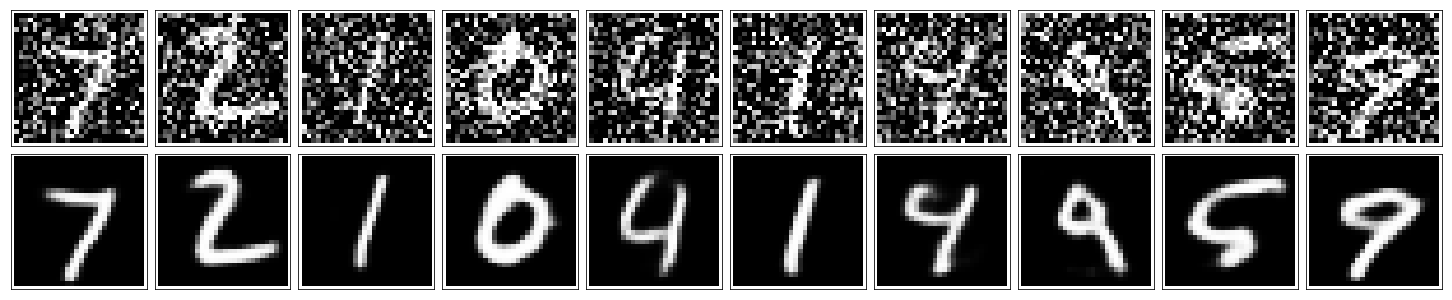

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)